In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
# define the path where my modules are saved
module_path = 'home/m/m300909/clear sky feedback/'
# add this path tho the system path using the `sys` module
if not module_path in sys.path: sys.path.append(module_path)
# load them as they were regular python packages.
# (the file is called home/m/m300909/py_data_handling.py)
import cir_func as cf
import basic_func as bf
import rad_func as rf

# Control scenario

In [3]:
path = '/work/mh0066/m300909/mpiesm-landveg/mpiesm-landveg-3D/experiments/'
sst = ''
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs_{sst}rotation_'
experiment = ['003125x', '00625x', '0125x', '025x', '05x', '1x', '2x', '4x', '8x']
output_dir = '/newdata/'
model = '_echam6'
file_type = '_BOT'
time = '_1976_2015'
suffix = '.nc'

file_name = [
    f"{setup}{exp}{model}{file_type}{time}{suffix}" for exp in experiment
]

In [4]:
ctrl = {}

rotation = ['1/32', '1/16', '1/8', '1/4', '1/2', 'Earth-like', '2', '4', '8']

for i, rot in enumerate(rotation):
    ctrl[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

# Warming scenario

In [5]:
sst = '_1K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type}{time}{suffix}" for exp in experiment
]

warm_1K = {}

for i, rot in enumerate(rotation):
    warm_1K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [6]:
sst = '_2K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type}{time}{suffix}" for exp in experiment
]

warm_2K = {}

for i, rot in enumerate(rotation):
    warm_2K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [7]:
sst = '_3K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type}{time}{suffix}" for exp in experiment
]

warm_3K = {}

for i, rot in enumerate(rotation):
    warm_3K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [8]:
sst = '_4K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type}{time}{suffix}" for exp in experiment
]

warm_4K = {}

for i, rot in enumerate(rotation):
    warm_4K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [9]:
data_2D = {
    'ctrl': ctrl, 
    '1K': warm_1K,
    '2K': warm_2K,
    '3K': warm_3K,
    '4K': warm_4K
}

In [10]:
def dict_to_xarray(data, rotation, var, time_slice=None):

    data_ls = []
    
    for key, rot in data.items():
        data_ls.append(rot[var].sel(time=time_slice))

    # Convert the list of mean profiles into an xarray DataArray
    data_da = xr.concat(data_ls, dim='rotation')
    data_da['rotation'] = rotation
    return data_da

# Clear-sky response

In [11]:
colormap = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

warm_response = {}

# Precompute control data arrays
lw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'traf0', 
                            ('rotation',rotation), time_slice)

sw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'sraf0', 
                            ('rotation',rotation), time_slice)

rad_flux_ctrl = lw_ctrl + sw_ctrl
tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation',rotation), time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    lw_flux = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation',rotation), time_slice)
    sw_flux = bf.dict_to_xarray(data, 'sraf0', 
                                ('rotation',rotation), time_slice)
    rad_flux = lw_flux + sw_flux
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                                ('rotation',rotation), time_slice)

    # Compute the clear-sky longwave radiation response
    clrsky_response = bf.feedback_parameter(rad_flux, rad_flux_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    clrsky_response_mean = bf.global_mean_weighted(clrsky_response)
    clrsky_response_error = bf.global_std_error(clrsky_response)

    if key not in warm_response:
        warm_response[key] = {} 

    # Store the response and associated color
    warm_response[key]['clrsky'] = {'mean': clrsky_response_mean, 
                                    'error':clrsky_response_error,
                                     'color': colormap[i+1]}
         

In [12]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}


clrsky = {}
# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):

    # Convert data to xarray
    lw_clrsky = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation', rotation) , time_slice)
    
    lw_clrsky_mean = bf.global_mean_weighted(lw_clrsky)
    lw_clrsky_error = bf.global_std_error(lw_clrsky)

    if key not in clrsky:
        clrsky[key] = {}

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    clrsky[key]['lw'] = {'mean': lw_clrsky_mean, 
                          'error':lw_clrsky_error,
                          'color': color} 

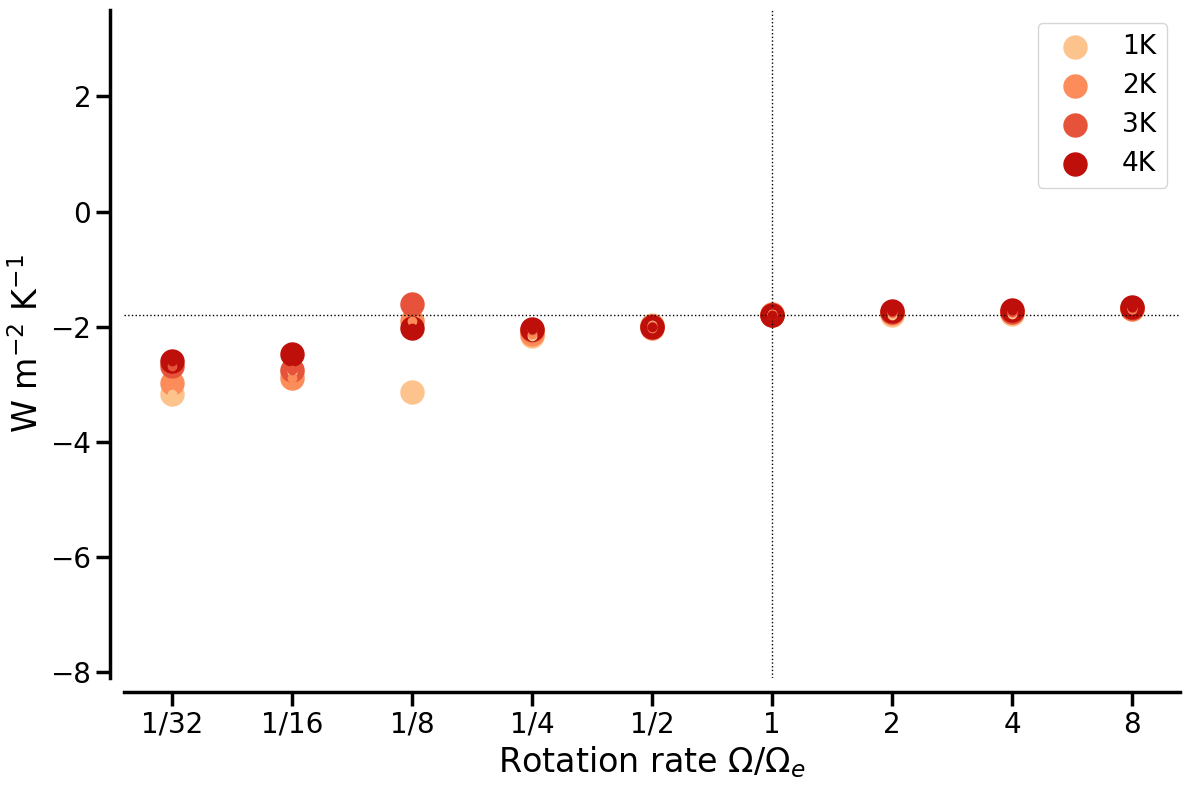

In [15]:
from matplotlib.ticker import ScalarFormatter
ylabel = 'clear-sky feedback / W m$^{-2}$ K$^{-1}$'
ylabel = 'W m$^{-2}$ K$^{-1}$'
y_lim = [-3.6,-0.3]
y_lim = [-8.1,3.5]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))


for key, var in warm_response.items():
    #if key in ['2K','3K']:
        #continue
    y = var['clrsky']['mean'] 
    std = var['clrsky']['error']
    color = var['clrsky']['color']

    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    #ax.plot(x, y, color = color, linewidth = 4)
    ax.errorbar(x, y , yerr = std, fmt = 'o', color = color, 
                        ecolor='black', elinewidth=2, capsize=2)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
ax.set_ylim(y_lim[0],y_lim[1])
#ax.yaxis.set_inverted(True)


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc = 'upper right')
plt.axhline(y=y[5], color='k', linewidth=1, linestyle = 'dotted')
plt.axvline(x=5, color='k', linewidth=1, linestyle = 'dotted')

plt.tight_layout()
plt.savefig('Figures/clrsky_lw.pdf')

In [16]:
colormap = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

warm_response = {}

# Precompute control data arrays
lw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'traf0', 
                            ('rotation',rotation), time_slice)

sw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'sraf0', 
                            ('rotation',rotation), time_slice)

rad_flux_ctrl = lw_ctrl + sw_ctrl
tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation',rotation), time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    lw_flux = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation',rotation), time_slice)
    sw_flux = bf.dict_to_xarray(data, 'sraf0', 
                                ('rotation',rotation), time_slice)
    rad_flux = lw_flux + sw_flux
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                                ('rotation',rotation), time_slice)

    # Compute the clear-sky longwave radiation response
    clrsky_response = bf.feedback_parameter(rad_flux, rad_flux_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    clrsky_response_mean = clrsky_response.mean(dim=['time','lon'])
    clrsky_mean = rad_flux.mean(dim=['time','lon'])
    clrsky_ctrl_mean = rad_flux_ctrl.mean(dim=['time','lon'])

    if key not in warm_response:
        warm_response[key] = {} 

    # Store the response and associated color
    warm_response[key]['clrsky'] = {'mean': clrsky_response_mean, 
                                    'effect':clrsky_mean,
                                    'ctrl':clrsky_ctrl_mean,
                                     'color': colormap[i+1]}
         

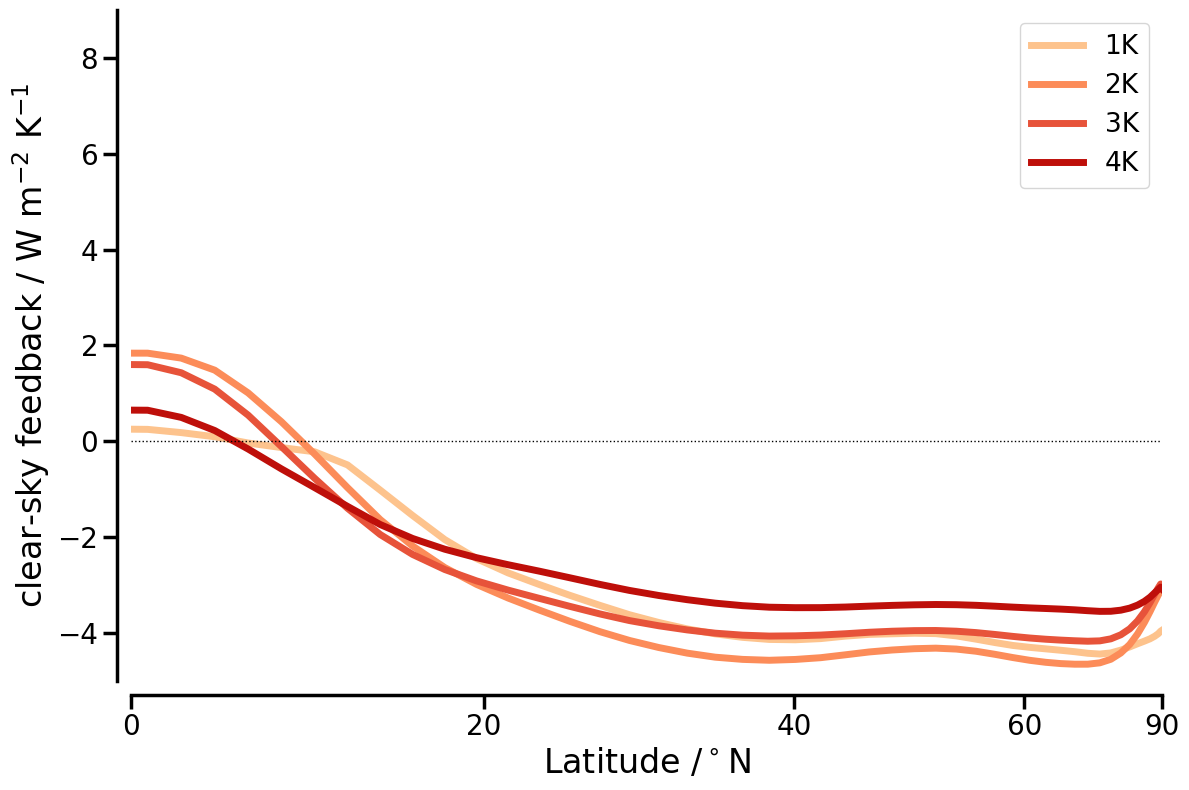

In [18]:
from matplotlib.ticker import ScalarFormatter
y_lim = [-5,9]
ylabel = 'clear-sky feedback / W m$^{-2}$ K$^{-1}$'

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))


#x.plot(x, var['lw cloud']['ctrl'].sel(rotation='1/16'), 
            #color='grey', linewidth=2, linestyle='solid', 
            #label='ctrl')
for key, var in warm_response.items():    
        
    y = var['clrsky']['mean'].sel(rotation='1/16')
    color = var['clrsky']['color']

    x = np.sin(np.deg2rad(var['clrsky']['mean'].lat))

    ax.plot(x, y, color=color, linewidth=5, linestyle='solid', 
            label=key)

    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
plt.legend(fontsize=19)
ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
ax.set_xticklabels(ticks_deg)
ax.set_ylabel(ylabel, size=24)
ax.set_xlim(0, np.sin(np.deg2rad(90)))
ax.set_ylim(y_lim)
plt.axhline(y=0, color='k', linewidth=1, linestyle = 'dotted')



plt.xlabel('Latitude /'r'$^\circ$N', size=24)
plt.tight_layout()
plt.savefig('Figures/cloud_response.pdf')

# Precipitable water

In [19]:
colormap = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

water_vapour = {}

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
   
    if key == 'ctrl':
        color = 'grey'
    else:
        color = colormap[i+1]

    # Convert data to xarray
    water_precip = bf.dict_to_xarray(data, 'qvi', ('rotation', rotation),
                                     time_slice)

    
    water_precip_response_mean = bf.global_mean_weighted(water_precip)
    water_precip_response_error = bf.global_std_error(water_precip)

    if key not in water_vapour:
        water_vapour[key] = {}

    # Store the response and associated color
    water_vapour[key]['precip water'] = {'mean': water_precip_response_mean, 
                                    'error': water_precip_response_error,
                                     'color': color}
   

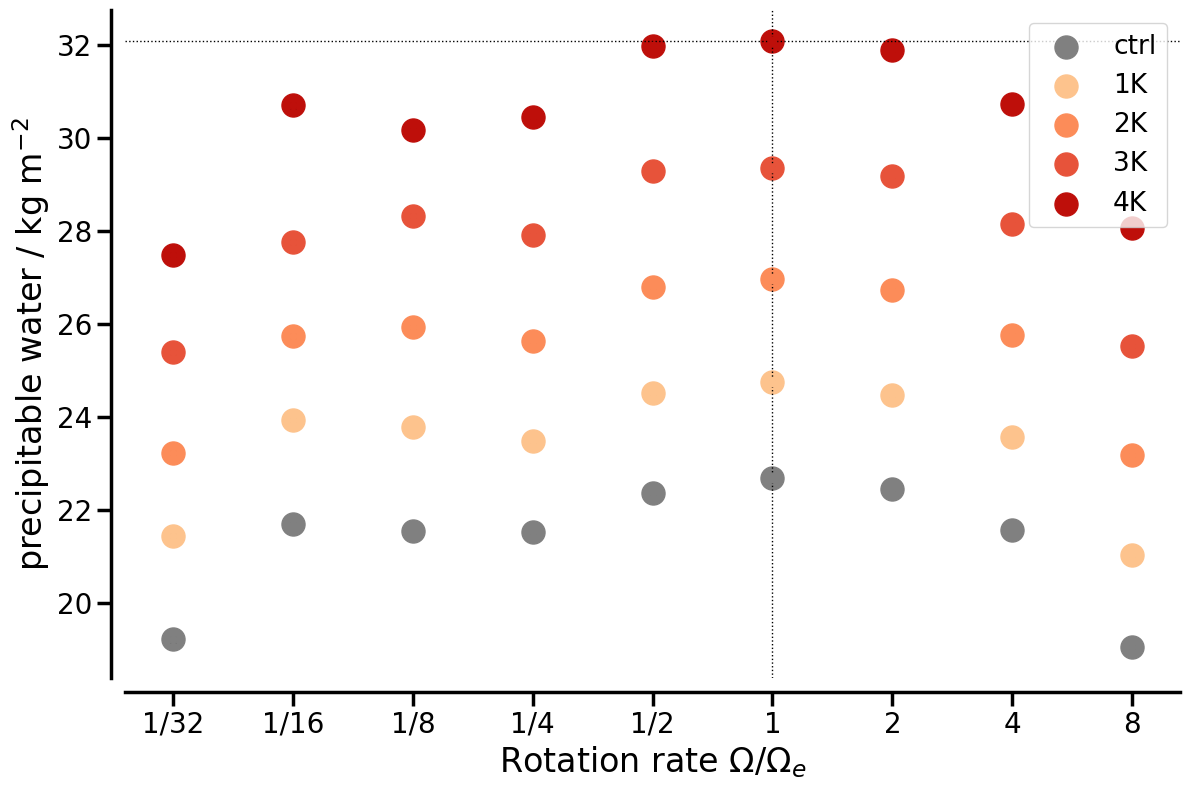

In [20]:
from matplotlib.ticker import ScalarFormatter
ylabel = 'precipitable water / kg m$^{-2}$'
y_lim = [-8, None]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))


for key, var in water_vapour.items():
    y = var['precip water']['mean']
    std = var['precip water']['error']
    color = var['precip water']['color']
    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    ax.errorbar(x, y , yerr = std, fmt = 'o', color = color, 
                        ecolor='black', elinewidth=2, capsize=2)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc = 'upper right')
plt.axhline(y=y[5], color='k', linewidth=1, linestyle = 'dotted')
plt.axvline(x=5, color='k', linewidth=1, linestyle = 'dotted')

plt.tight_layout()
plt.savefig('Figures/water_vapour_response.pdf')

# All-sky response

In [17]:
colormap = plt.cm.Greens(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
lw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'trad0', 
                            ('rotation', rotation) , time_slice)

sw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'srad0', 
                            ('rotation', rotation) , time_slice)

rad_flux_ctrl = lw_ctrl + sw_ctrl

tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation', rotation) , time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    lw_flux = bf.dict_to_xarray(data, 'trad0', 
                                ('rotation', rotation) , time_slice)
    
    sw_flux = bf.dict_to_xarray(data, 'srad0', 
                                ('rotation', rotation) , time_slice)
    
    rad_flux = lw_flux + sw_flux 
    
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                              ('rotation', rotation) , time_slice)

    # Compute the clear-sky longwave radiation response
    allsky_response = bf.feedback_parameter(rad_flux, rad_flux_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    allsky_response_mean = bf.global_mean_weighted(allsky_response)
    allsky_response_error = bf.global_std_error(allsky_response)


    # Store the response and associated color
    warm_response[key]['allsky'] = {'mean': allsky_response_mean, 
                          'error':allsky_response_error,
                          'color': colormap[i+1]} 


In [18]:
colormap = plt.cm.Blues(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
lw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'trad0', 
                            ('rotation', rotation) , time_slice)

sw_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'srad0', 
                            ('rotation', rotation) , time_slice)

rad_flux_ctrl = lw_ctrl + sw_ctrl

temp_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation', rotation) , time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    lw_flux = bf.dict_to_xarray(data, 'trad0', 
                                ('rotation', rotation) , time_slice)
    
    sw_flux = bf.dict_to_xarray(data, 'srad0', 
                                ('rotation', rotation) , time_slice)
    
    rad_flux = lw_flux + sw_flux 
    
    temp = bf.dict_to_xarray(data, 'tsurf', 
                              ('rotation', rotation) , time_slice)

    eff_response = bf.feedback_parameter(rad_flux, rad_flux_ctrl, 
                                             temp, temp_ctrl)
    eff_response_mean = bf.global_mean_weighted(eff_response)
    eff_response_error = bf.global_std_error(eff_response)

    eff_sensitivity_mean = 3.6 / (-1 * eff_response_mean)
    #eff_sensitivity_mean = bf.global_mean_weighted(eff_sensitivity)
    #eff_sensitivity_error = bf.global_std_error(eff_sensitivity)
    
    warm_response[key]['effective response'] = {'mean': eff_response_mean, 
                          'error':eff_response_error,
                          'color': colormap[i+1]} 
    
    warm_response[key]['effective sensitivity'] = {'mean': eff_sensitivity_mean, 
                          #'error':eff_sensitivity_error,
                          'color': colormap[i+1]} 

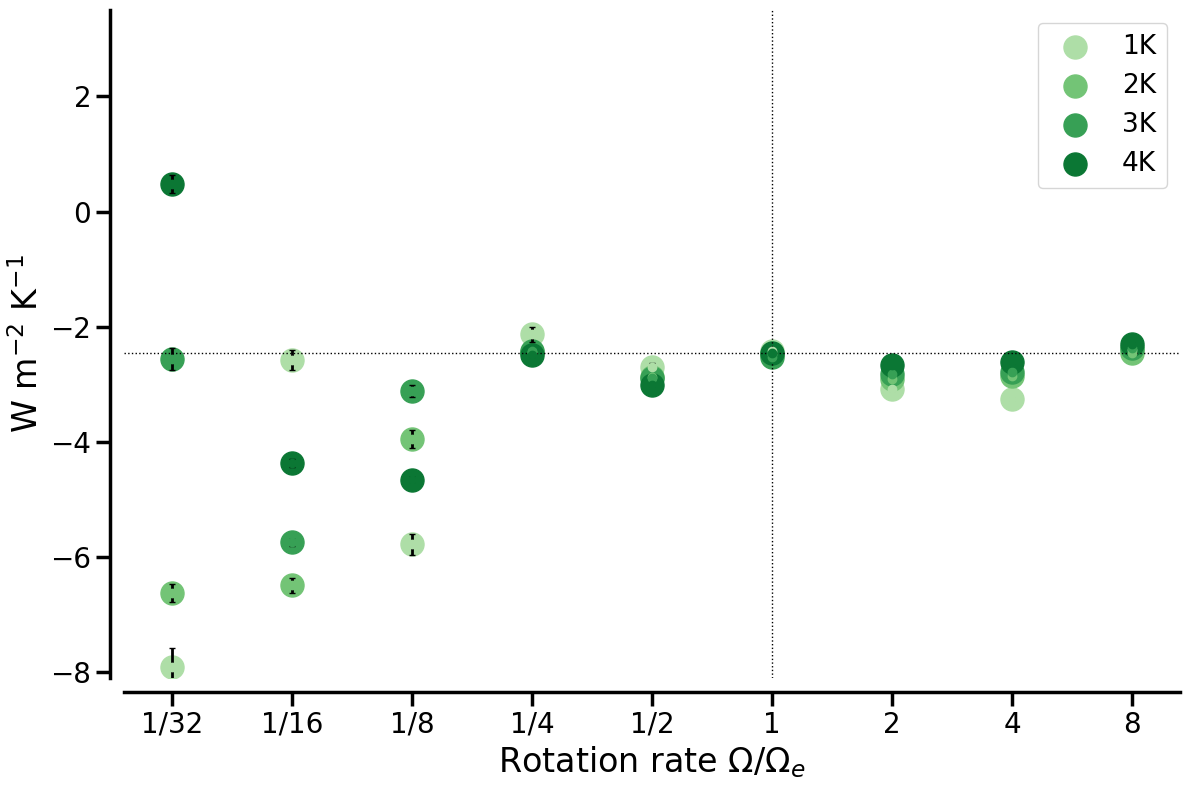

In [19]:
from matplotlib.ticker import ScalarFormatter
ylabel = 'radiative feedback / W m$^{-2}$ K$^{-1}$'
ylabel = 'W m$^{-2}$ K$^{-1}$'
#y_lim = [-5,2.5]
y_lim = [-8.1,3.5]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))


for key, var in warm_response.items():
    #if key in ['2K','3K']:
        #continue
    y = var['allsky']['mean'] 
    std = var['allsky']['error']
    color = var['allsky']['color']

    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    #ax.plot(x, y, color = color, linewidth = 4)
    ax.errorbar(x, y , yerr = std, fmt = 'o', color = color, 
                        ecolor='black', elinewidth=2, capsize=2)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
ax.set_ylim(y_lim[0],y_lim[1])
#ax.yaxis.set_inverted(True)


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc = 'upper right')
plt.axhline(y=y[5], color='k', linewidth=1, linestyle = 'dotted')
plt.axvline(x=5, color='k', linewidth=1, linestyle = 'dotted')

plt.tight_layout()
plt.savefig('Figures/allsky_lw.pdf')

# Cloud response

In [20]:
colormap = plt.cm.Blues(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
sw_allsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'srad0', 
                            ('rotation', rotation) , time_slice)

lw_allsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'trad0', 
                            ('rotation', rotation) , time_slice)

sw_clrsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'sraf0', 
                            ('rotation', rotation) , time_slice)

lw_clrsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'traf0', 
                            ('rotation', rotation) , time_slice)

cloud_ctrl = (sw_allsky_ctrl + lw_allsky_ctrl) - (sw_clrsky_ctrl + lw_clrsky_ctrl)

tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation', rotation) , time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    sw_allsky = bf.dict_to_xarray(data, 'srad0', 
                                ('rotation', rotation) , time_slice)

    lw_allsky = bf.dict_to_xarray(data, 'trad0', 
                                ('rotation', rotation) , time_slice)
    
    sw_clrsky = bf.dict_to_xarray(data, 'sraf0', 
                                ('rotation', rotation) , time_slice)

    lw_clrsky = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation', rotation) , time_slice)
    
    cloud = (sw_allsky + lw_allsky) - (sw_clrsky + lw_clrsky) 
    
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                              ('rotation', rotation) , time_slice)

    # Compute the cloud response
    cloud_response = bf.feedback_parameter(cloud, cloud_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    cloud_response_mean = bf.global_mean_weighted(cloud_response)
    cloud_response_error = bf.global_std_error(cloud_response)

    # Store the response and associated color
    warm_response[key]['cloud'] = {'mean': cloud_response_mean, 
                          'error': cloud_response_error,
                          'color': colormap[i+1]} 

## SW

In [21]:
colormap = plt.cm.Blues(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
sw_allsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'srad0', 
                            ('rotation', rotation) , time_slice)

sw_clrsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'sraf0', 
                            ('rotation', rotation) , time_slice)

sw_cloud_ctrl = sw_allsky_ctrl - sw_clrsky_ctrl

tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation', rotation) , time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    sw_allsky = bf.dict_to_xarray(data, 'srad0', 
                                ('rotation', rotation) , time_slice)
    
    sw_clrsky = bf.dict_to_xarray(data, 'sraf0', 
                                ('rotation', rotation) , time_slice)
    
    sw_cloud = sw_allsky - sw_clrsky 
    
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                              ('rotation', rotation) , time_slice)

    # Compute the clear-sky longwave radiation response
    sw_cloud_response = bf.feedback_parameter(sw_cloud, sw_cloud_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    sw_cloud_response_mean = bf.global_mean_weighted(sw_cloud_response)
    sw_cloud_response_error = bf.global_std_error(sw_cloud_response)

    # Store the response and associated color
    warm_response[key]['sw cloud'] = {'mean': sw_cloud_response_mean, 
                          'error':sw_cloud_response_error,
                          'color': colormap[i+1]} 

In [22]:
cm = plt.cm.Blues(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}


cloud = {}
# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):

    # Convert data to xarray
    sw_allsky = bf.dict_to_xarray(data, 'srad0', 
                                ('rotation', rotation) , time_slice)
    
    sw_clrsky = bf.dict_to_xarray(data, 'sraf0', 
                                ('rotation', rotation) , time_slice)
    
    sw_cloud = sw_allsky - sw_clrsky 
    
    sw_cloud_mean = bf.global_mean_weighted(sw_cloud)
    sw_cloud_error = bf.global_std_error(sw_cloud)

    if key not in cloud:
        cloud[key] = {}

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    cloud[key]['sw cloud'] = {'mean': sw_cloud_mean, 
                          'error':sw_cloud_error,
                          'color': color} 

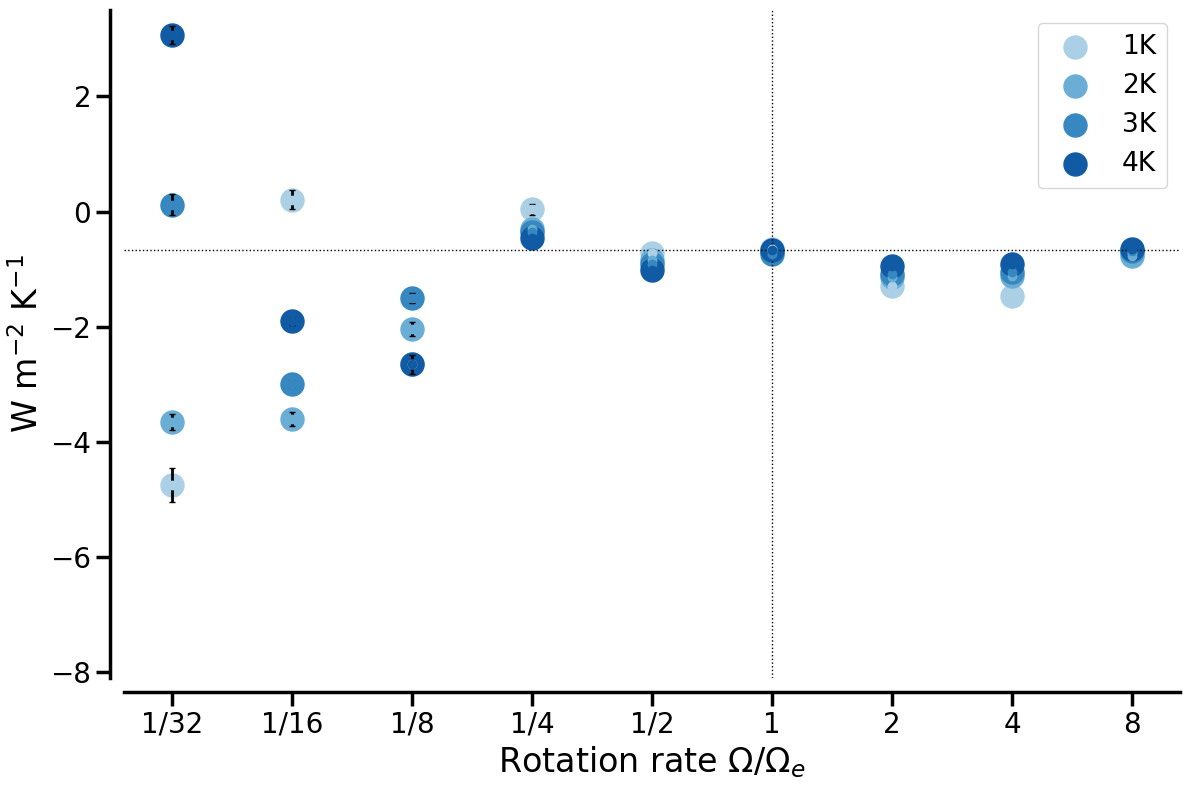

In [23]:
from matplotlib.ticker import ScalarFormatter
ylabel = 'cloud response / W m$^{-2}$ K$^{-1}$'
ylabel = 'W m$^{-2}$ K$^{-1}$'
y_lim = [-8.1,3.5]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))


for key, var in warm_response.items():
    y = var['cloud']['mean'] 
    std = var['cloud']['error']
    color = var['cloud']['color']
    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    ax.errorbar(x, y , yerr = std, fmt = 'o', color = color, 
                        ecolor='black', elinewidth=2, capsize=2)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
ax.set_ylim(y_lim[0],y_lim[1])
#ax.yaxis.set_inverted(True)


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc = 'upper right')
plt.axhline(y=y[5], color='k', linewidth=1, linestyle = 'dotted')
plt.axvline(x=5, color='k', linewidth=1, linestyle = 'dotted')

plt.tight_layout()
plt.savefig('Figures/cloud_response.pdf')

# All response plot

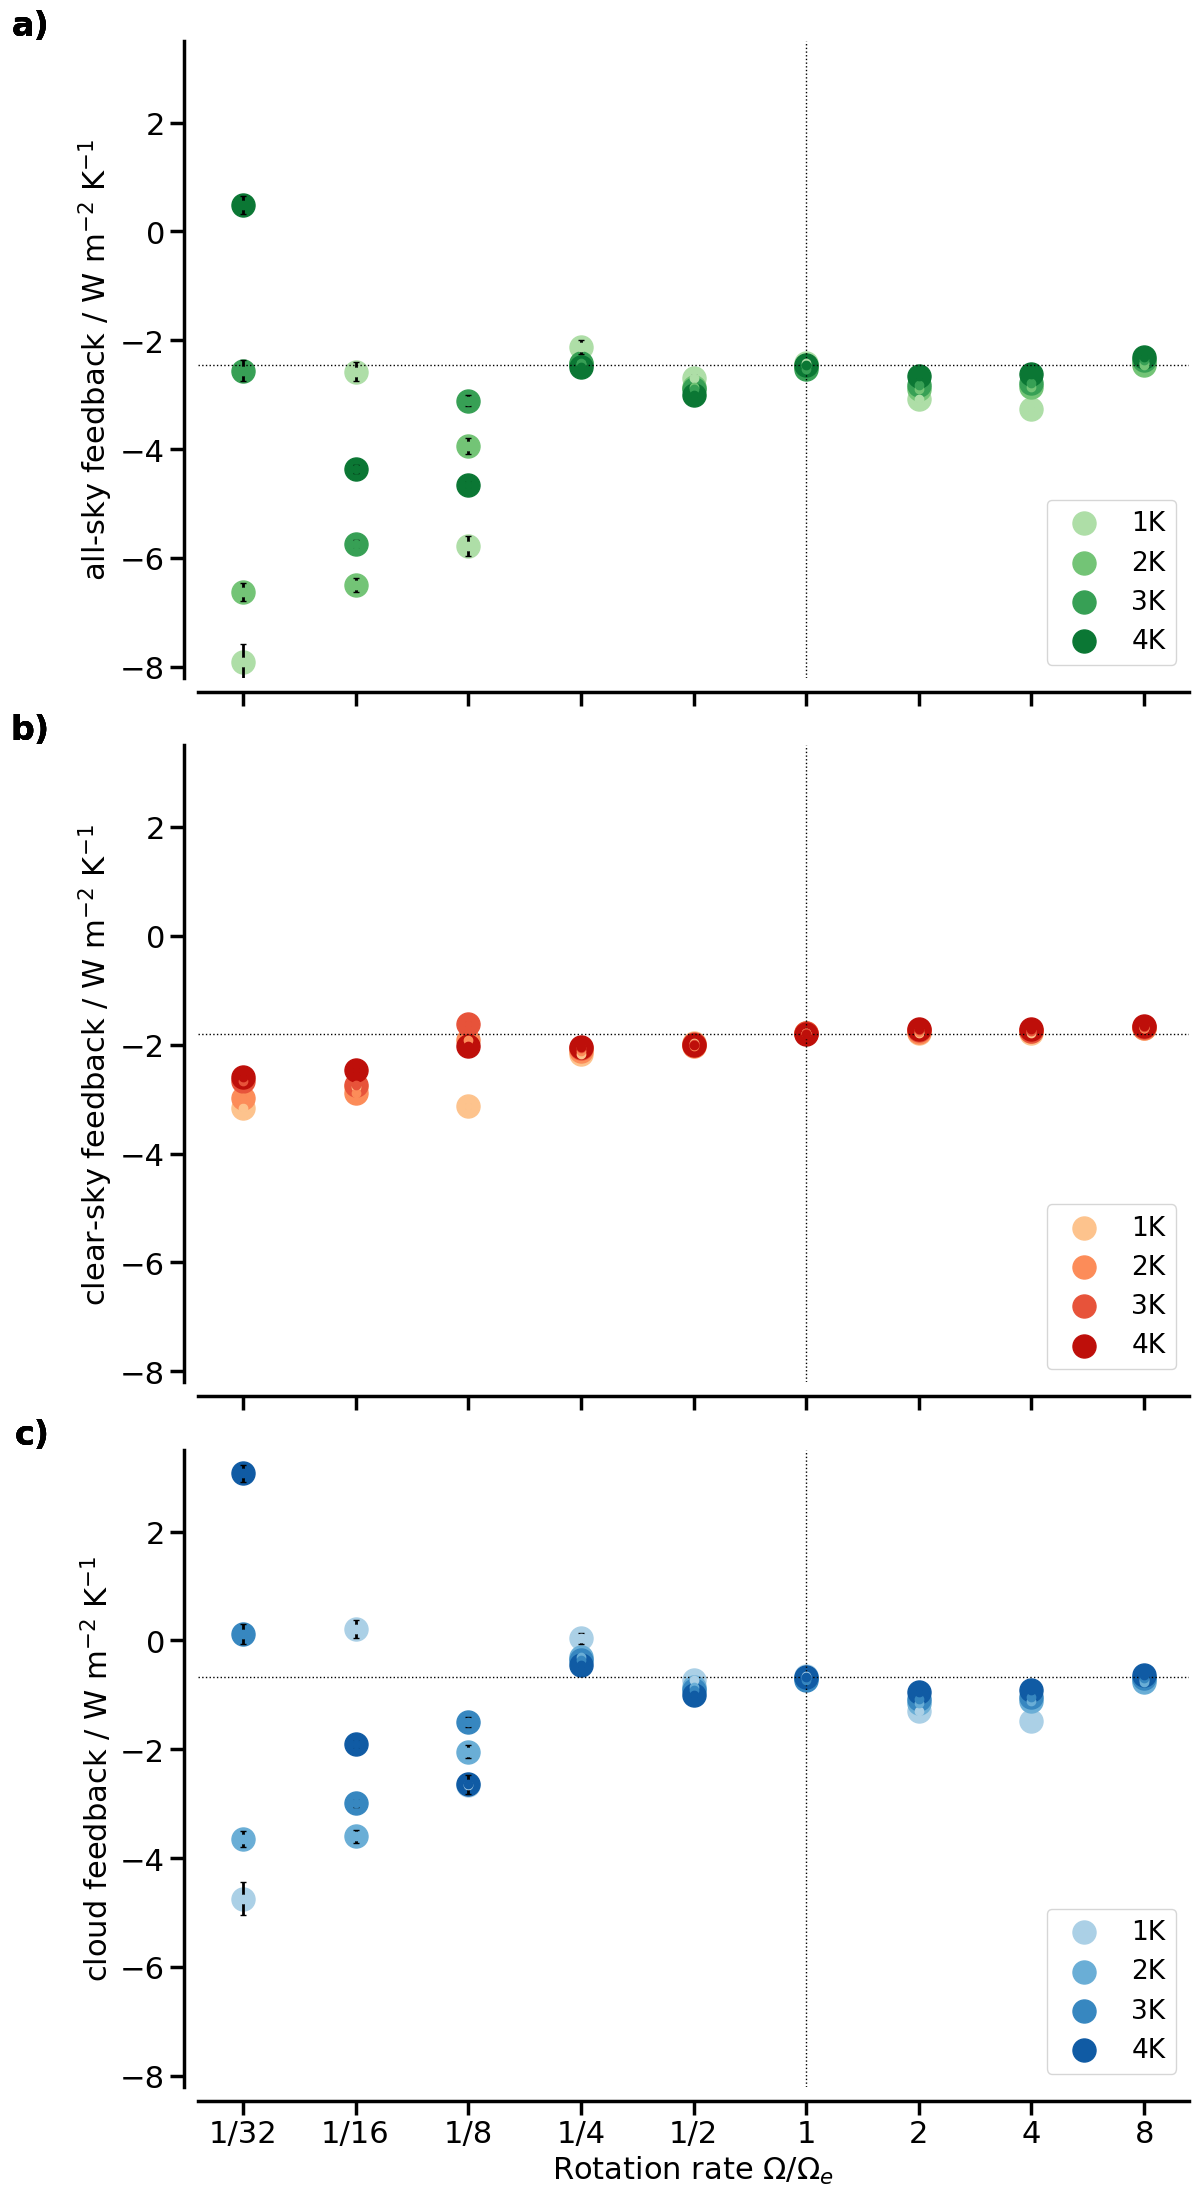

In [66]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 22), sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, xlabel=False, set_ticks=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_ylabel(ylabel, fontsize=22)
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    if xlabel:
        ax.set_xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=22)
    if ylim:
        ax.set_ylim(ylim)
    if set_ticks:
        ax.xaxis.set_ticks(x)
        ax.set_xticklabels([x for x in ticks])

# Iterate over axes

ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))
subplot_labels = ['a)', 'b)', 'c)']

for key, var in warm_response.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

    
        if i == 0:
            var_name = var['allsky']['mean']
            std = var['allsky']['error']
            color = var['allsky']['color']
            ylabel = 'all-sky feedback / W m$^{-2}$ K$^{-1}$'
            y_lim = [-8.2,3.5]
            configure_axes(ax, ylabel, ylim=y_lim)
        elif i == 1:
            var_name = var['clrsky']['mean']
            std = var['clrsky']['error']
            color = var['clrsky']['color']
            ylabel = 'clear-sky feedback / W m$^{-2}$ K$^{-1}$'
            configure_axes(ax, ylabel, ylim=y_lim)
        elif i == 2:
            var_name = var['cloud']['mean']
            std = var['cloud']['error']
            color = var['cloud']['color']
            ylabel = 'cloud feedback / W m$^{-2}$ K$^{-1}$'
            configure_axes(ax, ylabel, ylim=y_lim, xlabel=True, set_ticks=[x, ticks])

        ax.scatter(x, var_name, color=color, label=key, marker='o', s=275)
        ax.errorbar(x, var_name, yerr=std, fmt='o', color=color, 
                    ecolor='black', elinewidth=2, capsize=2)

        ax.legend(fontsize=19, loc='lower right')
        if key in ['4K']:
            ax.axhline(y=var_name[5], color='k', linewidth=1, linestyle='dotted')
            ax.axvline(x=5, color='k', linewidth=1, linestyle='dotted')

plt.tight_layout()
plt.savefig('Figures/radiative_feedback.pdf')

## LW

In [96]:
colormap = plt.cm.RdPu(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
lw_allsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'trad0', 
                            ('rotation', rotation) , time_slice)

lw_clrsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'traf0', 
                            ('rotation', rotation) , time_slice)

lw_cloud_ctrl = lw_allsky_ctrl - lw_clrsky_ctrl

tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation', rotation) , time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    lw_allsky = bf.dict_to_xarray(data, 'trad0', 
                                ('rotation', rotation) , time_slice)
    
    lw_clrsky = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation', rotation) , time_slice)
    
    lw_cloud = lw_allsky - lw_clrsky 
    
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                              ('rotation', rotation) , time_slice)

    # Compute the clear-sky longwave radiation response
    lw_cloud_response = bf.feedback_parameter(lw_cloud, lw_cloud_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    lw_cloud_response_mean = bf.global_mean_weighted(lw_cloud_response)
    lw_cloud_response_error = bf.global_std_error(lw_cloud_response)

    # Store the response and associated color
    warm_response[key]['lw cloud'] = {'mean': lw_cloud_response_mean, 
                          'error':lw_cloud_response_error,
                          'color': colormap[i+1]} 

In [97]:
cm = plt.cm.RdPu(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}


# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):

    # Convert data to xarray
    lw_allsky = bf.dict_to_xarray(data, 'trad0', 
                                ('rotation', rotation) , time_slice)
    
    lw_clrsky = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation', rotation) , time_slice)
    
    lw_cloud = lw_allsky - lw_clrsky 
    
    lw_cloud_mean = bf.global_mean_weighted(lw_cloud)
    lw_cloud_error = bf.global_std_error(lw_cloud)

    if key not in cloud:
        cloud[key] = {}

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    cloud[key]['lw cloud'] = {'mean': lw_cloud_mean, 
                          'error':lw_cloud_error,
                          'color': color} 

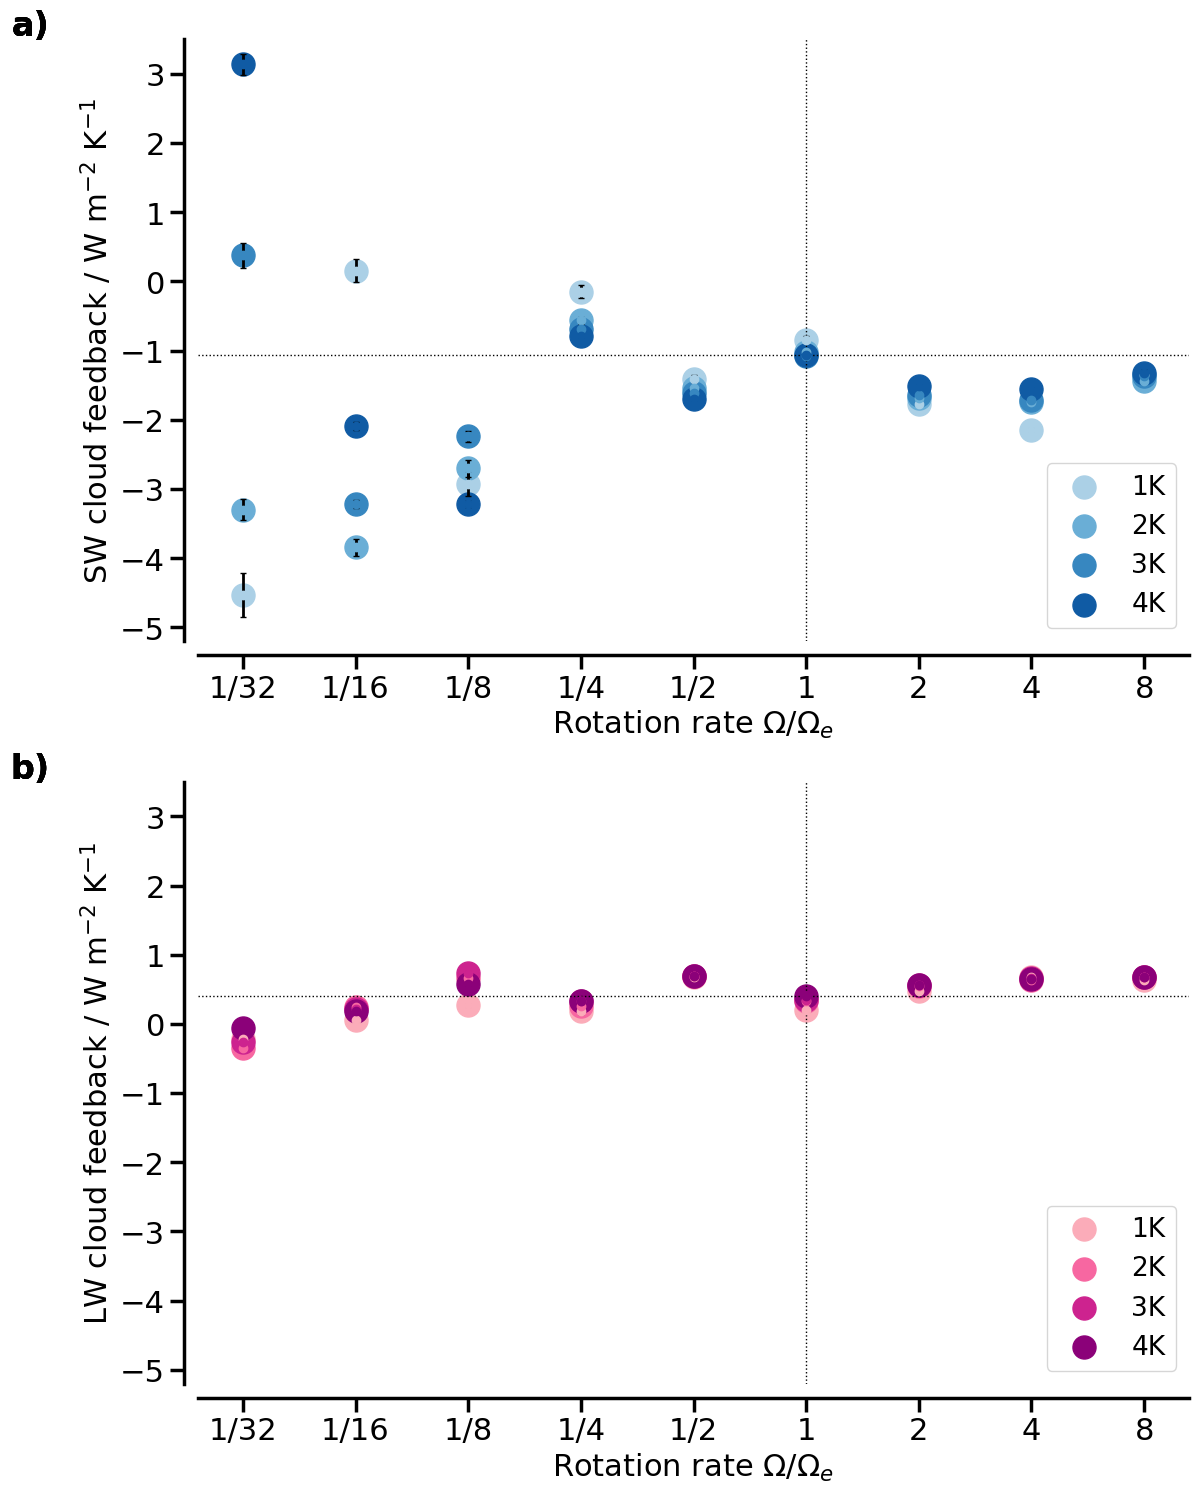

In [100]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))#, sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, xlabel=False, set_ticks=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_ylabel(ylabel, fontsize=22)
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    if xlabel:
        ax.set_xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=22)
    if ylim:
        ax.set_ylim(ylim)
    if set_ticks:
        ax.xaxis.set_ticks(x)
        ax.set_xticklabels([x for x in ticks])

# Iterate over axes

ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))
#subplot_labels = ['a)', 'b)', 'c)']

for key, var in warm_response.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

        if i == 0:
            var_name = var['sw cloud']['mean']
            std = var['sw cloud']['error']
            color = var['sw cloud']['color']
            ylabel = 'SW cloud feedback / W m$^{-2}$ K$^{-1}$'
            y_lim = [-5.2,3.5]
            configure_axes(ax, ylabel, ylim=y_lim, xlabel=True, set_ticks=[x, ticks])
        elif i == 1:
            var_name = var['lw cloud']['mean']
            std = var['lw cloud']['error']
            color = var['lw cloud']['color']
            ylabel = 'LW cloud feedback / W m$^{-2}$ K$^{-1}$'
            y_lim = [-5.2,3.5]
            configure_axes(ax, ylabel, ylim=y_lim, xlabel=True, set_ticks=[x, ticks])

        ax.scatter(x, var_name, color=color, label=key, marker='o', s=275)
        ax.errorbar(x, var_name, yerr=std, fmt='o', color=color, 
                    ecolor='black', elinewidth=2, capsize=2)

        ax.legend(fontsize=19, loc='lower right')
        if key in ['4K']:
            ax.axhline(y=var_name[5], color='k', linewidth=1, linestyle='dotted')
            ax.axvline(x=5, color='k', linewidth=1, linestyle='dotted')

plt.tight_layout()
plt.savefig('Figures/cloud_feedback.pdf')

In [22]:
colormap = plt.cm.RdPu(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
lw_allsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'trad0', 
                            ('rotation', rotation) , time_slice)

lw_clrsky_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'traf0', 
                            ('rotation', rotation) , time_slice)

lw_cloud_ctrl = lw_allsky_ctrl - lw_clrsky_ctrl

tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], 'tsurf', 
                            ('rotation', rotation) , time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    if key == 'ctrl':
        continue

    # Convert data to xarray
    lw_allsky = bf.dict_to_xarray(data, 'trad0', 
                                ('rotation', rotation) , time_slice)
    
    lw_clrsky = bf.dict_to_xarray(data, 'traf0', 
                                ('rotation', rotation) , time_slice)
    
    lw_cloud = lw_allsky - lw_clrsky 
    
    tsurf = bf.dict_to_xarray(data, 'tsurf', 
                              ('rotation', rotation) , time_slice)

    # Compute the clear-sky longwave radiation response
    lw_cloud_response = bf.feedback_parameter(lw_cloud, lw_cloud_ctrl, 
                                             tsurf, tsurf_ctrl)
    
    lw_cloud_response_mean = lw_cloud_response.mean(dim=['time','lon'])
    lw_cloud_mean = lw_cloud.mean(dim=['time','lon'])
    lw_cloud_ctrl_mean = lw_cloud_ctrl.mean(dim=['time','lon'])

    # Store the response and associated color
    warm_response[key]['lw cloud'] = {'response': lw_cloud_response_mean,
                                      'effect':lw_cloud_mean,
                                      'ctrl':lw_cloud_ctrl_mean,
                                      'color': colormap[i+1]} 

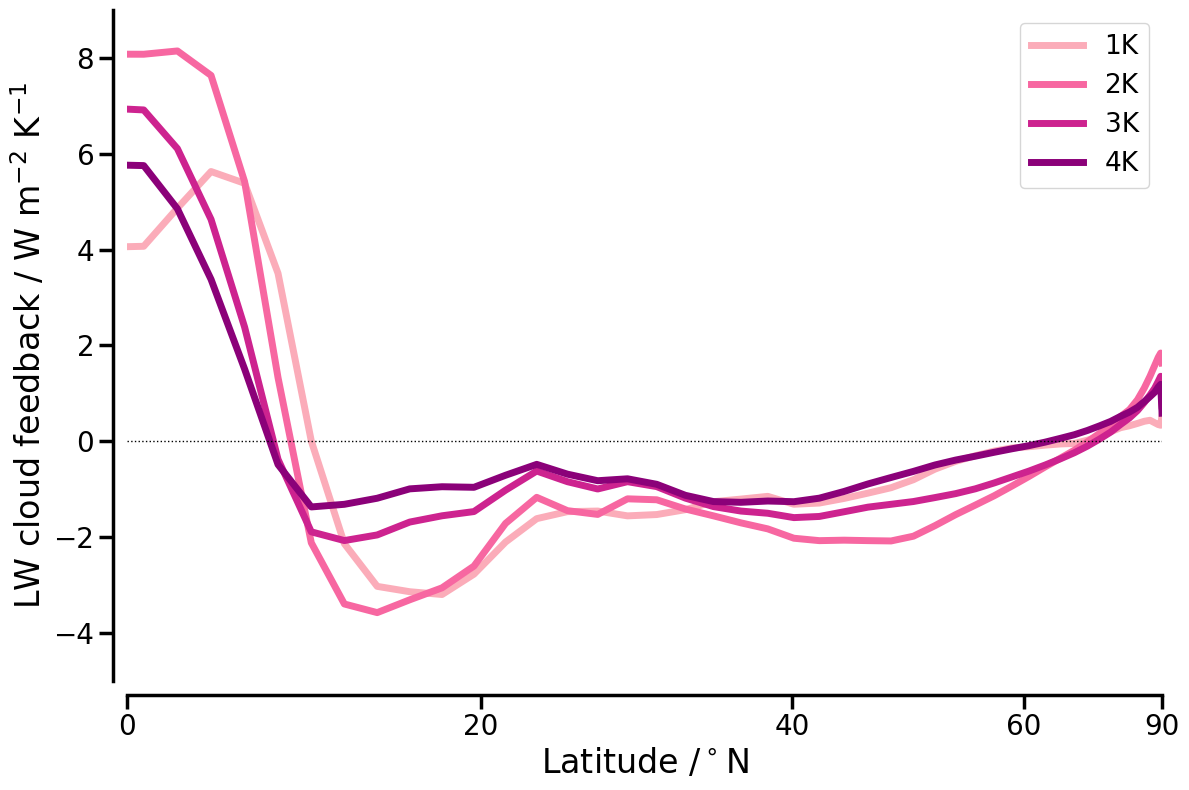

In [23]:
from matplotlib.ticker import ScalarFormatter
y_lim = [-5,9]
ylabel = 'LW cloud feedback / W m$^{-2}$ K$^{-1}$'

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))


#x.plot(x, var['lw cloud']['ctrl'].sel(rotation='1/16'), 
            #color='grey', linewidth=2, linestyle='solid', 
            #label='ctrl')
for key, var in warm_response.items():    
        
    y = var['lw cloud']['response'].sel(rotation='1/32')
    color = var['lw cloud']['color']

    x = np.sin(np.deg2rad(var['lw cloud']['response'].lat))

    ax.plot(x, y, color=color, linewidth=5, linestyle='solid', 
            label=key)

    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
plt.legend(fontsize=19)
ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
ax.set_xticklabels(ticks_deg)
ax.set_ylabel(ylabel, size=24)
ax.set_xlim(0, np.sin(np.deg2rad(90)))
ax.set_ylim(y_lim)
plt.axhline(y=0, color='k', linewidth=1, linestyle = 'dotted')



plt.xlabel('Latitude /'r'$^\circ$N', size=24)
plt.tight_layout()
plt.savefig('Figures/cloud_response.pdf')

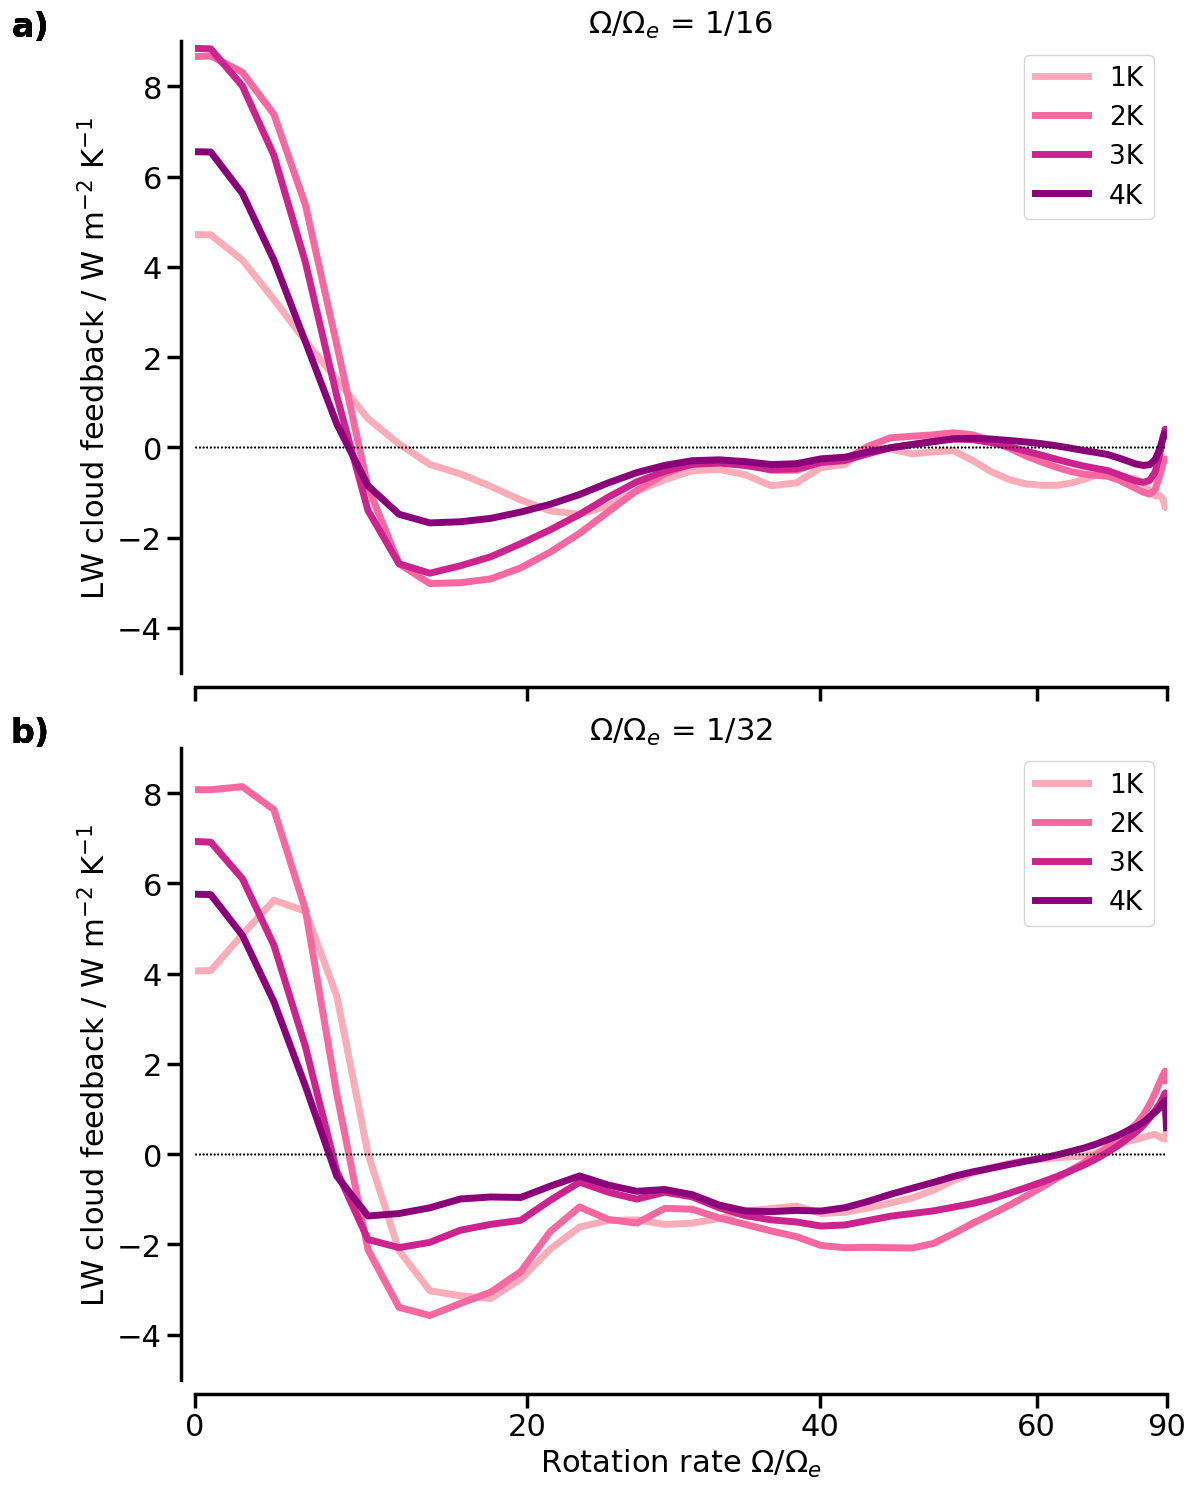

In [24]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15), sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, xlabel=False, title=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_ylabel(ylabel, fontsize=22)
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    if xlabel:
        ax.set_xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=22)
    if ylim:
        ax.set_ylim(ylim)
    if title:
        ax.set_title(title, size=22)

# Iterate over axes
subplot_labels = ['a)', 'b)', 'c)']

for key, var in warm_response.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

        if i == 0:
            var_name = var['lw cloud']['response'].sel(rotation='1/16')
            color = var['lw cloud']['color']
            x = np.sin(np.deg2rad(var['lw cloud']['response'].lat))
            configure_axes(ax, ylabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = var['lw cloud']['response'].sel(rotation='1/32')
            color = var['lw cloud']['color']
            x = np.sin(np.deg2rad(var['lw cloud']['response'].lat))
            ylabel = 'LW cloud feedback / W m$^{-2}$ K$^{-1}$'
            configure_axes(ax, ylabel, ylim=y_lim, xlabel=True, title=r'$\Omega/\Omega_e$ = 1/32')

        ax.plot(x, var_name, color=color, linewidth=5, linestyle='solid', 
            label=key)

        ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
        ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
        ax.set_xticklabels(ticks_deg)
        ax.set_xlim(0, np.sin(np.deg2rad(90)))
        ax.axhline(y=0, color='k', linewidth=1, linestyle = 'dotted')
        ax.legend(fontsize=19, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/lw_cloud_feedback.pdf')

## Cloud fraction

In [15]:
colormap = plt.cm.Blues(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

cloud = {}

# Precompute control data arrays
#cloud_fraction_ctrl = bf.dict_to_xarray(data_2D['ctrl'], rotation, 'aclcov', time_slice)
#tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], rotation, 'tsurf', time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
   
    if key == 'ctrl':
        color = 'grey'
    else:
        color = colormap[i+1]

    # Convert data to xarray
    cloud_fraction = bf.dict_to_xarray(data, rotation, 'aclcov', time_slice)
    #tsurf = bf.dict_to_xarray(data, rotation, 'tsurf', time_slice)

    # Compute the clear-sky longwave radiation response
    #cloud_fraction_response = fun.feedback_parameter(cloud_fraction_ctrl, cloud_fraction, 
    #                                         tsurf_ctrl, tsurf)
    
    cloud_fraction_response_mean = bf.global_mean_weighted(cloud_fraction)
    cloud_fraction_response_error = bf.global_std_error(cloud_fraction)

    if key not in cloud:
        cloud[key] = {}

    # Store the response and associated color
    cloud[key]['cloud fraction'] = {'mean': cloud_fraction_response_mean, 
                                    'error':cloud_fraction_response_error,
                                     'color': color}
         

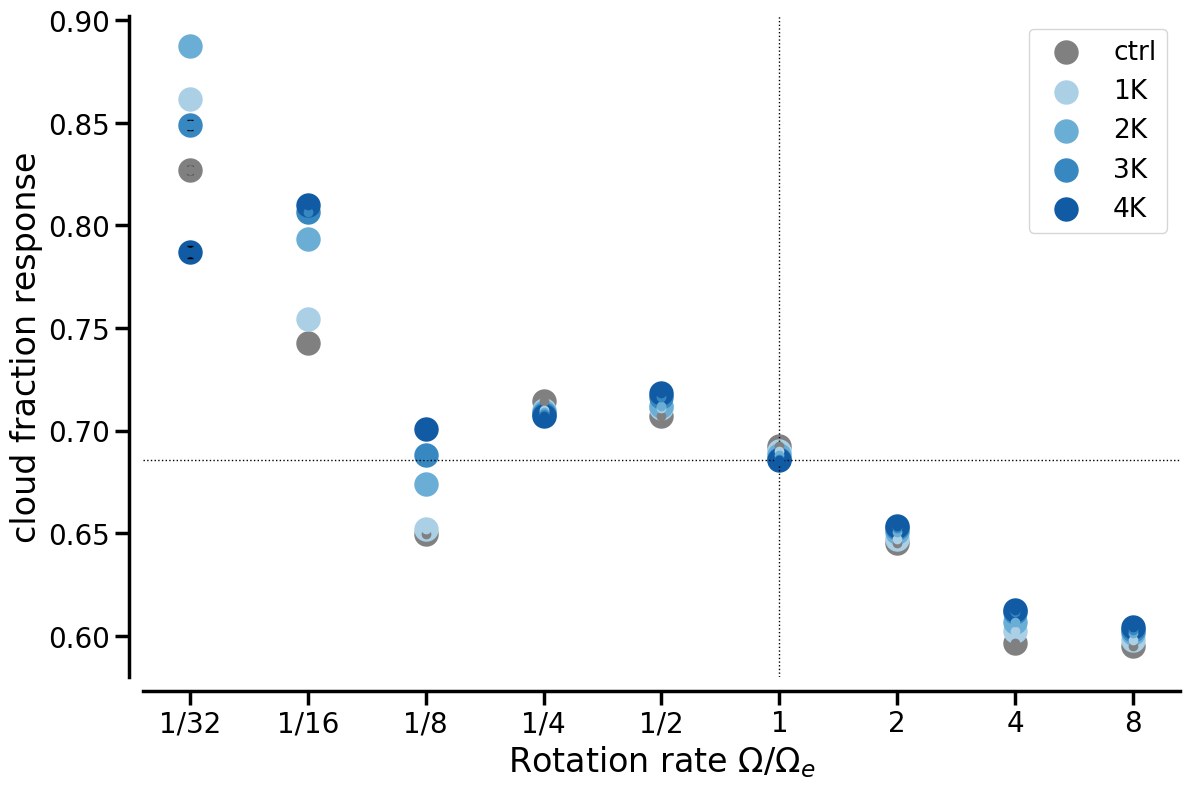

In [16]:
from matplotlib.ticker import ScalarFormatter
ylabel = 'cloud fraction response'
y_lim = [-8, None]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))


for key, var in cloud.items():
    y = var['cloud fraction']['mean']
    std = var['cloud fraction']['error']
    color = var['cloud fraction']['color']
    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    ax.errorbar(x, y , yerr = std, fmt = 'o', color = color, 
                        ecolor='black', elinewidth=2, capsize=2)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc = 'upper right')
plt.axhline(y=y[5], color='k', linewidth=1, linestyle = 'dotted')
plt.axvline(x=5, color='k', linewidth=1, linestyle = 'dotted')

plt.tight_layout()
plt.savefig('Figures/cloud_response.pdf')

## Cloud water

In [17]:
colormap = plt.cm.Blues(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)

# Precompute control data arrays
#cloud_water_ctrl = bf.dict_to_xarray(data_2D['ctrl'], rotation, 'xlvi', time_slice)
#tsurf_ctrl = bf.dict_to_xarray(data_2D['ctrl'], rotation, 'tsurf', time_slice)

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_2D.items()):
    
    if key == 'ctrl':
        color = 'grey'
    else:
        color = colormap[i+1]

    # Convert data to xarray
    cloud_water = bf.dict_to_xarray(data, rotation, 'xlvi', time_slice)
    #tsurf = bf.dict_to_xarray(data, rotation, 'tsurf', time_slice)

    # Compute the clear-sky longwave radiation response
    #cloud_water_response = fun.feedback_parameter(cloud_water_ctrl, cloud_water, 
    #                                         tsurf_ctrl, tsurf)
    
    cloud_water_response_mean = bf.global_mean_weighted(cloud_water)
    cloud_water_response_error = bf.global_std_error(cloud_water)

    # Store the response and associated color
    cloud[key]['cloud water'] = {'mean': cloud_water_response_mean, 
                                    'error': cloud_water_response_error,
                                     'color': color}
         

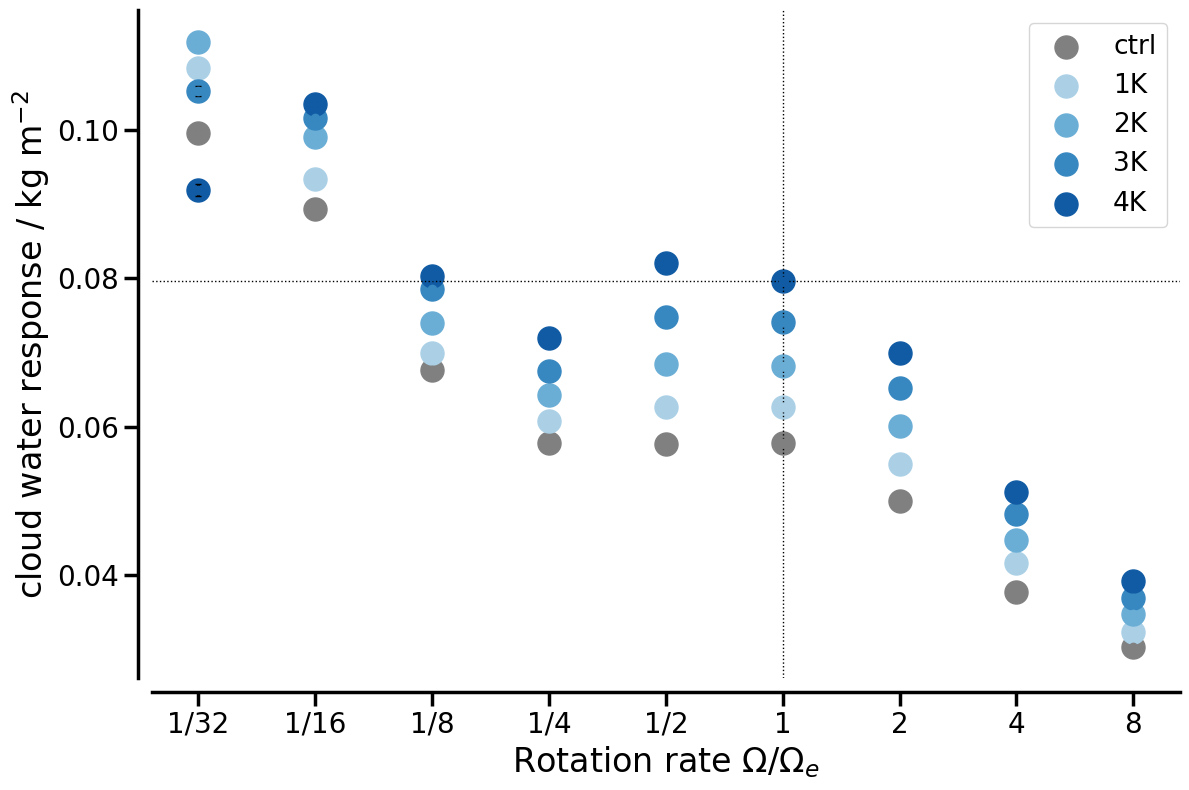

In [18]:
from matplotlib.ticker import ScalarFormatter
ylabel = 'cloud water response / kg m$^{-2}$'
y_lim = [-8, None]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
ticks[5] = '1'
x = np.arange(0, len(ticks))


for key, var in cloud.items():
    y = var['cloud water']['mean']
    std = var['cloud water']['error']
    color = var['cloud water']['color']
    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    ax.errorbar(x, y , yerr = std, fmt = 'o', color = color, 
                        ecolor='black', elinewidth=2, capsize=2)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc = 'upper right')
plt.axhline(y=y[5], color='k', linewidth=1, linestyle = 'dotted')
plt.axvline(x=5, color='k', linewidth=1, linestyle = 'dotted')

plt.tight_layout()
plt.savefig('Figures/cloud_response.pdf')

# Responses in 3D variables

In [13]:
path = '/work/mh0066/m300909/mpiesm-landveg/mpiesm-landveg-3D/experiments/'
sst = ''
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs_{sst}rotation_'
experiment = ['003125x', '00625x', '0125x', '025x', '05x', '1x', '2x', '4x', '8x']
experiment = ['00625x', '1x', '4x']
output_dir = '/newdata/'
model = '_echam6'
file_type = ['_ATM', '_mastrfu', '_tdiag']
time = '_1976_2015'
suffix = '.nc'

file_name0 = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

file_name1 = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

In [14]:
ctrl = {}
ctrl_sf = {}

rotation = ['1/32', '1/16', '1/8', '1/4', '1/2', 'Earth-like', '2', '4', '8']
#rotation = ['1/32', '1/16', '1/8', '1/4']
rotation = [ '1/16', 'Earth-like', '4']

for i, rot in enumerate(rotation):
    ctrl[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name0[i],
        decode_times='true'
    )

    ctrl_sf[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name1[i],
        decode_times='true'
    )

In [15]:
sst = '_1K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name0 = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

file_name1 = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_1K = {}
warm_1K_sf = {}

for i, rot in enumerate(rotation):
    warm_1K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name0[i],
        decode_times='true'
    )
    
    warm_1K_sf[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name1[i],
        decode_times='true'
    )


sst = '_2K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name0 = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

file_name1 = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_2K = {}
warm_2K_sf= {}

for i, rot in enumerate(rotation):
    warm_2K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name0[i],
        decode_times='true'
    )
    
    warm_2K_sf[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name1[i],
        decode_times='true'
    )


sst = '_3K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name0 = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

file_name1 = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_3K = {}
warm_3K_sf= {}

for i, rot in enumerate(rotation):
    warm_3K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name0[i],
        decode_times='true'
     )
    
    warm_3K_sf[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name1[i],
        decode_times='true'
     )

sst = '_4K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name0 = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

file_name1 = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_4K = {}
warm_4K_sf= {}

for i, rot in enumerate(rotation):
    warm_4K[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name0[i],
        decode_times='true'
     )
    
    warm_4K_sf[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name1[i],
        decode_times='true'
     )

In [16]:
data_3D = {
    'ctrl': ctrl, 
    '1K': warm_1K,
    '2K': warm_2K,
    '3K': warm_3K,
    '4K': warm_4K
}

In [17]:
data_mastrfu = {
    'ctrl': ctrl_sf, 
    '1K': warm_1K_sf,
    '2K': warm_2K_sf,
    '3K': warm_3K_sf,
    '4K': warm_4K_sf
}

## CRH histogram

In [15]:
def zonal_time_mean(data):
    """Compute the zonal time average"""
    return data.mean(dim=['lon','time'])


def pdf(data, iterate_dim: str = 'rotation'):
    import numpy as np
    import xarray as xr
    from scipy.stats import norm

    pdf = []
    for dim_val in data[iterate_dim]: 

        dim_data = data.sel({iterate_dim: dim_val})
        mu, sigma = norm.fit(dim_data)
        crh = np.linspace(0.01, 1, 99)
        pdf.append(norm.pdf(crh, mu, sigma))

    pdf_da = xr.DataArray(pdf, dims=[iterate_dim, 'crh'], 
                          coords={iterate_dim: data.coords[iterate_dim], 'crh': crh})
        
    return pdf_da

In [16]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

rh = {}

# Iterate over the data, skipping the 'ctrl' key
for i, (key, data) in enumerate(data_3D.items()):

    # Convert data to xarray
    q = bf.dict_to_xarray(data, 'q', ('rotation',rotation), time_slice)
    T = bf.dict_to_xarray(data, 'st', ('rotation',rotation), time_slice)

    r_col = rf.column_relative_humidity(q, T, slice(100000, 10000))

    pdf_rcol = pdf(r_col.mean(dim=['time']))
    r_col_mean = r_col.mean(dim=['time','lon'])

    if key not in rh:
        rh[key] = {} 

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    rh[key]['crh'] = {'mean': r_col_mean,
                      'pdf': pdf_rcol,
                      'color': color}

In [28]:
rh['1K']['crh']['mean'].sel(rotation='1/16').min

<bound method DataArrayAggregations.min of <xarray.DataArray (lat: 96)>
array([0.39483613, 0.39701629, 0.39961267, 0.40251235, 0.40395197,
       0.40182892, 0.39575273, 0.38619704, 0.37355475, 0.35932281,
       0.34367575, 0.32748329, 0.31133525, 0.2959516 , 0.28162192,
       0.2684395 , 0.2566146 , 0.24661584, 0.23869519, 0.23292164,
       0.22912305, 0.22719575, 0.22744615, 0.23016415, 0.23508303,
       0.24222242, 0.25152181, 0.26300167, 0.2768605 , 0.29322135,
       0.31219557, 0.33371497, 0.35776362, 0.3841563 , 0.41276311,
       0.44384341, 0.47812722, 0.51569379, 0.5554888 , 0.59613603,
       0.63582199, 0.67235825, 0.70543121, 0.73266964, 0.75078167,
       0.76186785, 0.76890236, 0.7724348 , 0.77231645, 0.76859657,
       0.76156794, 0.75035544, 0.7320747 , 0.7048594 , 0.67195803,
       0.63573802, 0.59620635, 0.55584001, 0.5163019 , 0.47899312,
       0.44490293, 0.41397733, 0.38549964, 0.35920433, 0.33521128,
       0.31370664, 0.29473364, 0.27839102, 0.2645248 , 0.

/tmp/ipykernel_2049762/850569667.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks_deg)


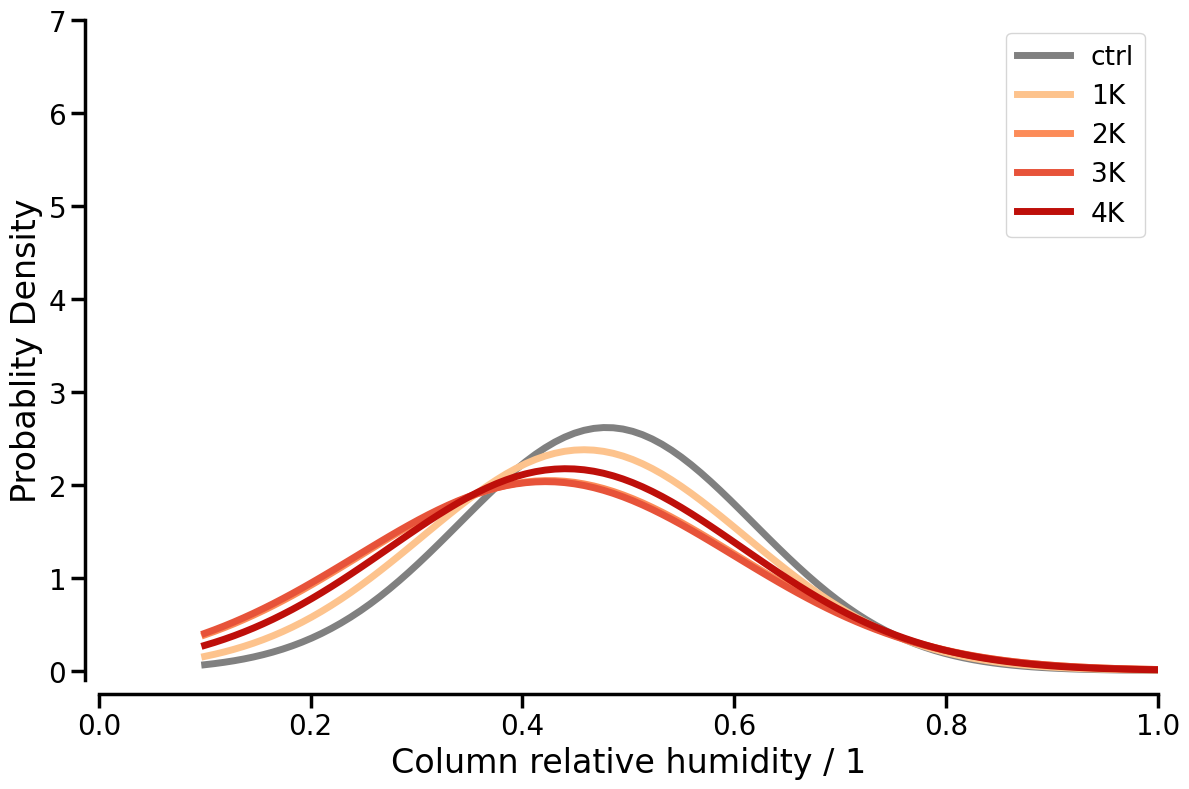

In [29]:
from matplotlib.ticker import ScalarFormatter
y_lim = [-3.5,-1]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))



for key, var in rh.items():
     y = var['crh']['pdf'].sel(rotation='1/16')
     color = var['crh']['color']

     x = var['crh']['pdf']['crh']
     x = np.sin(np.deg2rad(var['crh']['mean'].sel(rotation='4').lat))
     x = np.linspace(0.1, 1, 99)

     ax.plot(x, y, color=color, linewidth=5, linestyle='solid', 
            label=key)


y_lim = [-0.1, 7]
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
plt.legend(fontsize=19)
#ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
ticks_deg = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
#ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
ax.set_xticklabels(ticks_deg)
ax.set_xlabel('Column relative humidity / 1', size=24)
ax.set_ylabel('Probablity Density', size=24)
ax.set_xlim(0, np.sin(np.deg2rad(90)))
ax.set_ylim(y_lim[0], y_lim[1])


#plt.xlabel('Latitude /'r'$^\circ$N', size=24)
plt.tight_layout()
plt.savefig('Figures/histogram_fast.pdf')

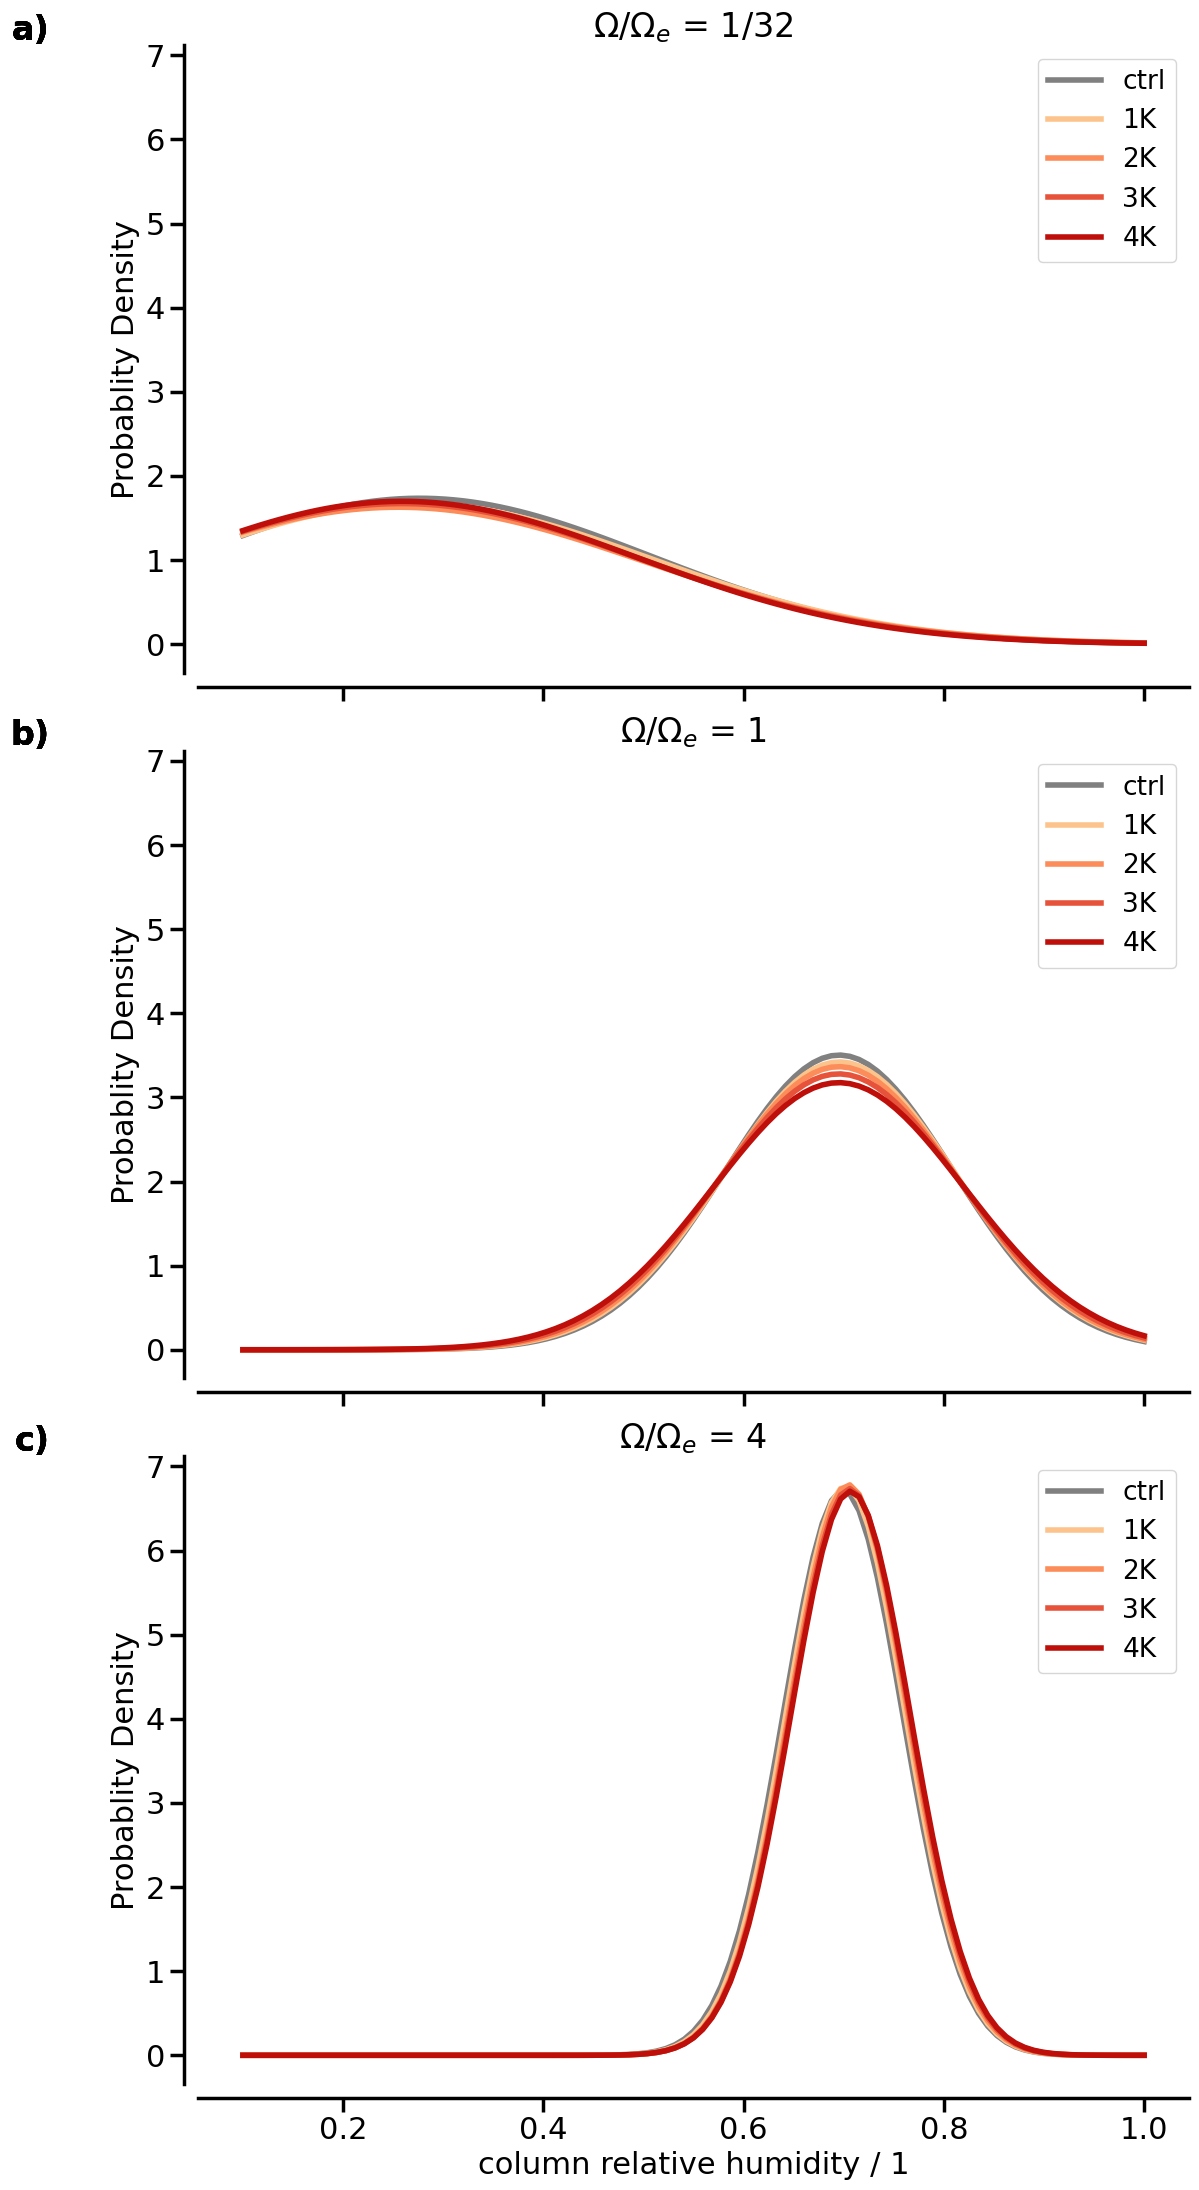

In [18]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 22), sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, title=None, xlabel=False, set_ticks=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=22)
    if xlabel:
        ax.set_xlabel('column relative humidity / 1', size=22)
    #if ylim:
        #ax.set_ylim(ylim)

# Iterate over axes

x = np.linspace(0.1, 1, 99)
subplot_labels = ['a)', 'b)', 'c)']


for key, var in rh.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

    
        if i == 0:
            var_name = var['crh']['pdf'].sel(rotation='1/32')
            color = var['crh']['color']
            y_lim = None#[-0.1, 7]
            ylabel = 'Probablity Density'
            configure_axes(ax, ylabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 1/32')
        elif i == 1:
            var_name = var['crh']['pdf'].sel(rotation='Earth-like')
            color = var['crh']['color']
            y_lim = None#[-0.1, 7]
            ylabel = 'Probablity Density'
            configure_axes(ax, ylabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 1')
        elif i == 2:
            var_name = var['crh']['pdf'].sel(rotation='4')
            color = var['crh']['color']
            y_lim = None#[-0.1, 7]
            ylabel = 'Probablity Density'
            configure_axes(ax, ylabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 4',xlabel=True)

        ax.plot(x, var_name, color=color, linewidth=4, linestyle='solid', 
            label=key)

        ax.legend(fontsize=19, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/crh_histogram.pdf')

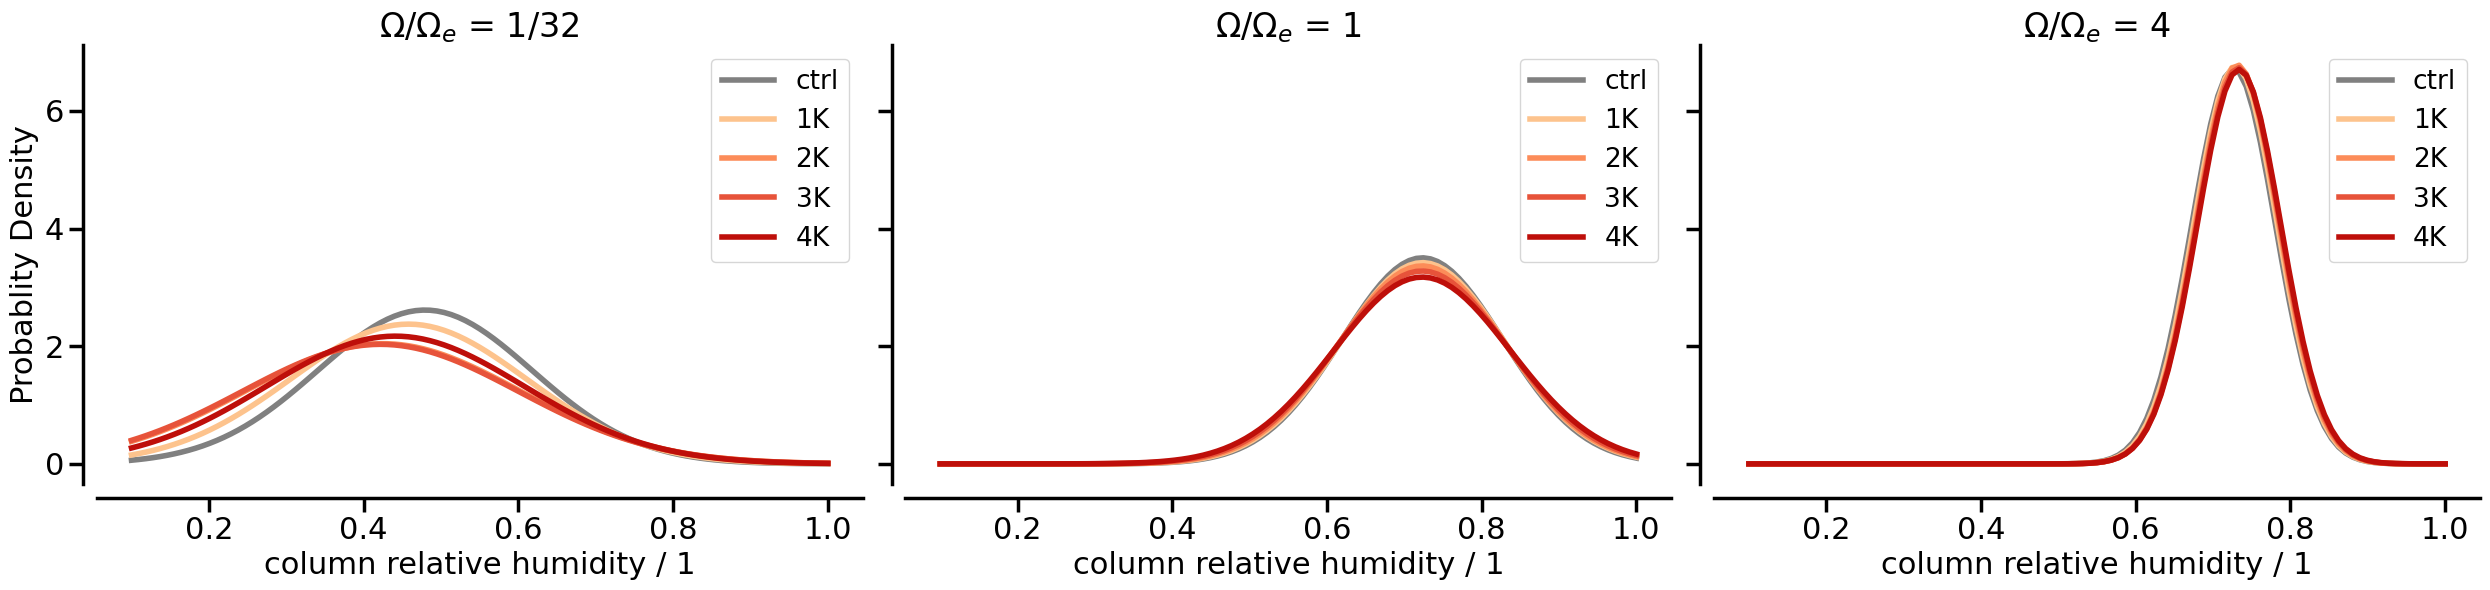

In [23]:
from matplotlib.ticker import ScalarFormatter

# Change nrows to 1 and ncols to 3 for horizontal layout
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6), sharex='row', sharey=True)
axes = axes.ravel()

def configure_axes(ax, xlabel, ylim=None, title=None, ylabel=False, set_ticks=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.set_title(title, fontsize=24)
    ax.set_xlabel(xlabel, fontsize=22)
    if ylabel:
        ax.set_ylabel('Probablity Density', size=22)
    #if ylim:
        #ax.set_ylim(ylim)

# Iterate over axes

x = np.linspace(0.1, 1, 99)
subplot_labels = ['a)', 'b)', 'c)']

for key, var in rh.items():
    for i, ax in enumerate(axes):
        #ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                #fontsize=24, fontweight='bold', va='top', ha='right')

        if i == 0:
            var_name = var['crh']['pdf'].sel(rotation='1/16')
            color = var['crh']['color']
            y_lim = None#[-0.1, 7]
            xlabel = 'column relative humidity / 1'
            configure_axes(ax, xlabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 1/32', ylabel=True)
        elif i == 1:
            var_name = var['crh']['pdf'].sel(rotation='Earth-like')
            color = var['crh']['color']
            y_lim = None#[-0.1, 7]
            configure_axes(ax, xlabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 1')
        elif i == 2:
            var_name = var['crh']['pdf'].sel(rotation='4')
            color = var['crh']['color']
            y_lim = None#[-0.1, 7]
            xlabel = 'column relative humidity / 1'
            configure_axes(ax, xlabel, ylim=y_lim, title=r'$\Omega/\Omega_e$ = 4')

        ax.plot(x, var_name, color=color, linewidth=4, linestyle='solid', 
            label=key)

        ax.legend(fontsize=19, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/crh_histogram.pdf')

## Aggregation

### Hadley extent

In [26]:
colormap = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528, 20151231.996528)

hadley_extent = {}

# Iterate over both data_ATM and data_mastrfu
for i, (key, data) in enumerate(data_mastrfu.items()):
    
    mastrfu = bf.dict_to_xarray(data, 'mastrfu', ('rotation', rotation), time_slice)

    mastrfu_north = mastrfu.mean(dim=['time', 'lon']).sel(lat=slice(90, 5))

    latitude = cf.hadley_cell_extent(mastrfu_north, 30000, 70000)

    # Determine color
    if key == 'ctrl':
        color = 'grey'
    else:
        color = colormap[i+1]

    # Store results
    hadley_extent[key] = {
        'latitude': latitude,
        'color': color
    }

### CRH variance

In [48]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

crh_var = {}

# Iterate over the data, skipping the 'ctrl' key
for i, ((key, data),(key_h, hadley)) in enumerate(zip(data_3D.items(), hadley_extent.items())):

    # Convert data to xarray
    q = bf.dict_to_xarray(data, 'q', ('rotation',rotation), time_slice)
    T = bf.dict_to_xarray(data, 'st', ('rotation',rotation), time_slice)

    lat = hadley['latitude']

    r_col = column_relative_humidity(q, T)

    aggregation = crh_binning(r_col, lat)

    if key not in crh_var:
        crh_var[key] = {} 

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    crh_var[key]['crh'] = {'var': aggregation,
                      'color': color}

In [55]:
crh_var['2K']['crh']['var'].var(dim='bins')

<xarray.DataArray 'crh' (rotation: 4)>
array([0.05061209, 0.05192804, 0.05057358, 0.04304117])
Dimensions without coordinates: rotation

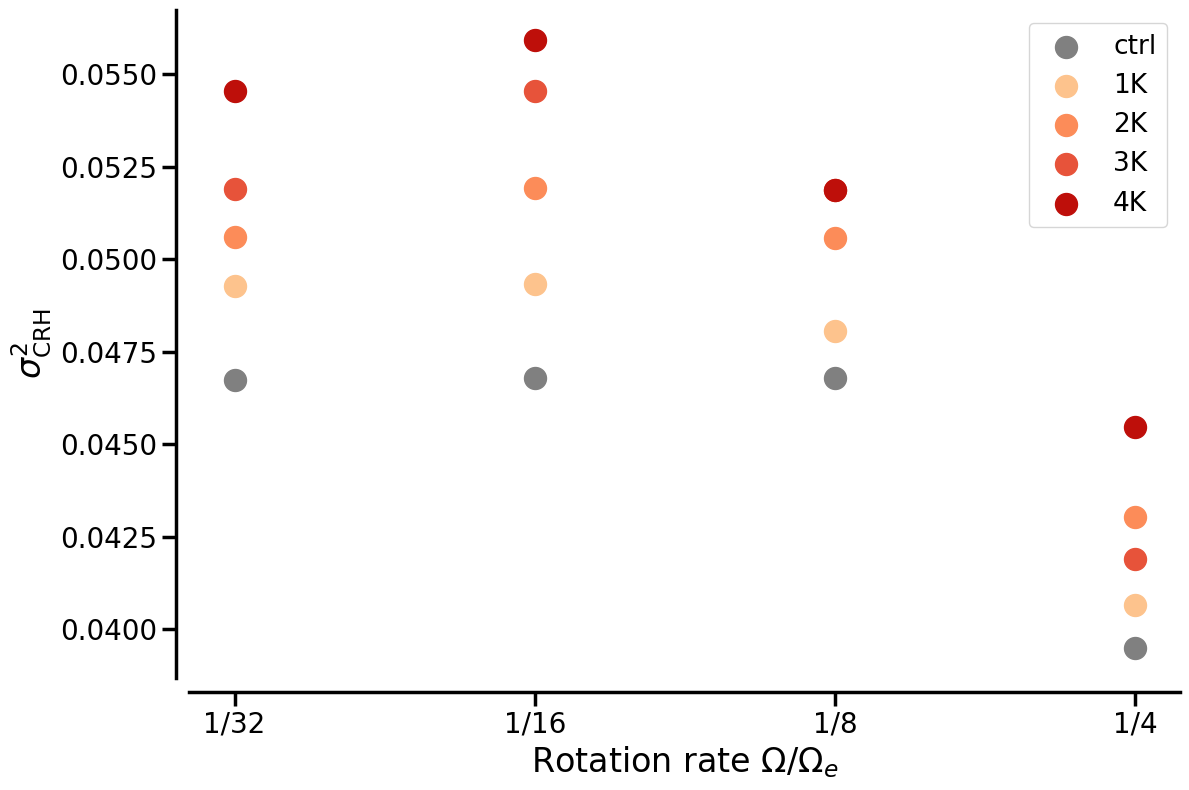

In [50]:
ylabel = ylabel = r'$\sigma^2_{\mathrm{CRH}}$'
y_lim=[25,90]


fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = ['1/32','1/16','1/8','1/4']# ,'1/2' , '1']
x = np.arange(0, len(ticks))

for key, var in crh_var.items():
    y = var['crh']['var'].var(dim='bins')
    ax.scatter(x, y, color = var['crh']['color'], label = key, 
            marker = 'o', s = 250)
        

ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19)

plt.tight_layout()
plt.savefig('Figures/aggregation.pdf')

## Subsidence fraction

In [23]:
def calculate_positive_omega_area(omega, hadley_extent=None):
    """
    Calculate the fraction of the area where omega is positive (subsidence) for each rotation.

    Parameters:
    - omega: xarray Dataset
      The dataset containing omega values with dimensions including 'plev' (pressure level) and 'rotation'.
    - plev: float or None
      The pressure level to select. If None, the nearest level to 40000 Pa is selected.
    - area_file: str
      Path to the NetCDF file containing the grid area information.
    - area_var: str
      The variable name in the area dataset that represents the cell area.

    Returns:
    - subsidence_fractions_da: xarray DataArray
      An array containing the fraction of the area with positive omega for each rotation.
    """
    
    # Load the dataset containing area information
    area_ds = xr.open_dataset('/work/mh0066/m300909/mpiesm-landveg/mpiesm-landveg/experiments/fixed_SST_1co2/aquaplanet_sponge_layer_rotation_1x/outdata/grid_area.nc')
    
    # Select the area variable from the dataset
    area = area_ds['cell_area']


    # Initialize a list to store the fraction of subsidence area for each rotation
    subsidence_fractions = []

    # Iterate over each rotation value in the omega dataset
    for i, rotation_val in enumerate(omega['rotation']):
        # Select the omega data slice corresponding to the current rotation
        omega_slice = omega.sel(rotation=rotation_val)

        hadley = hadley_extent[i]

        if hadley is not None:
            omega_slice = cf.within_hadley_cell(omega_slice, hadley)
        
        # Create a mask identifying regions where omega is positive (subsidence regions)
        subsidence_region_mask = omega_slice > 0
        
        # Apply the mask to the area dataset to get areas with positive omega
        subsidence_area = area.where(subsidence_region_mask, drop=True)
        
        # Calculate the total area where omega is positive
        total_subsidence_area = subsidence_area.sum()
        
        # Calculate the total area from the area dataset
        total_area = area.sum()
        
        # Calculate the fraction of the area with positive omega
        subsidence_fraction = total_subsidence_area / total_area
        
        # Append the calculated fraction to the list
        subsidence_fractions.append(subsidence_fraction)

    subsidence_fractions_da = xr.DataArray(subsidence_fractions, dims=['rotation'], 
                                           coords={'rotation': omega['rotation']})
    
    return subsidence_fractions_da

In [27]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

sub_frac = {}

# Iterate over the data, skipping the 'ctrl' key
for i, ((key, data),(key_h, hadley)) in enumerate(zip(data_3D.items(), hadley_extent.items())):

    # Convert data to xarray
    w = bf.dict_to_xarray(data, 'var135', ('rotation',rotation), time_slice)
    w = w.mean(dim=['time']).sel( plev = slice(30000, 20000))
    w = w.integrate('plev') * -1 / 9.8

    lat = hadley['latitude']

    area_frac = calculate_positive_omega_area(w, hadley_extent=lat)

    if key not in sub_frac:
        sub_frac[key] = {} 

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    sub_frac[key]['crh'] = {'var': area_frac,
                      'color': color}

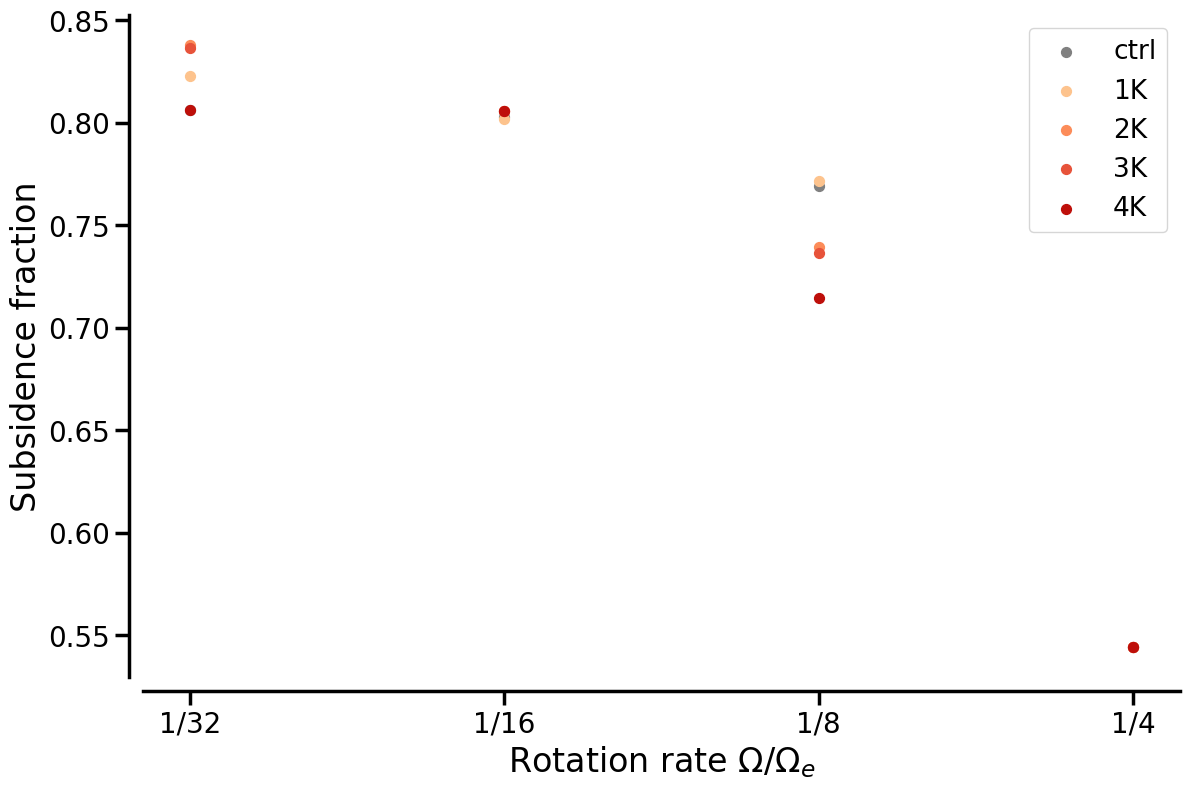

In [28]:
ylabel = ylabel = 'Subsidence fraction'
y_lim=[25,90]


fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = ['1/32','1/16','1/8','1/4']
#ticks = ['1/32', '1/16', '1/8', '1/4', '1/2', 'Earth-like', '2', '4', '8']
x = np.arange(0, len(ticks))

for key, var in sub_frac.items():
    y = var['crh']['var']
    ax.scatter(x, y, color = var['crh']['color'], label = key, 
            marker = 'o', s = 50)
        

ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19)

plt.tight_layout()
plt.savefig('Figures/aggregation.pdf')

## Mass stream function

In [18]:
time_slice = slice(19860131.996528,20151231.996528)
z1 = bf.dict_to_xarray(data_mastrfu['ctrl'], 'mastrfu', 
                       ('rotation',rotation), time_slice)
z1 = z1.mean(dim=['time','lon'])
z2 = bf.dict_to_xarray(data_mastrfu['4K'], 'mastrfu', 
                       ('rotation',rotation), time_slice)
z2 = z2.mean(dim=['time','lon'])

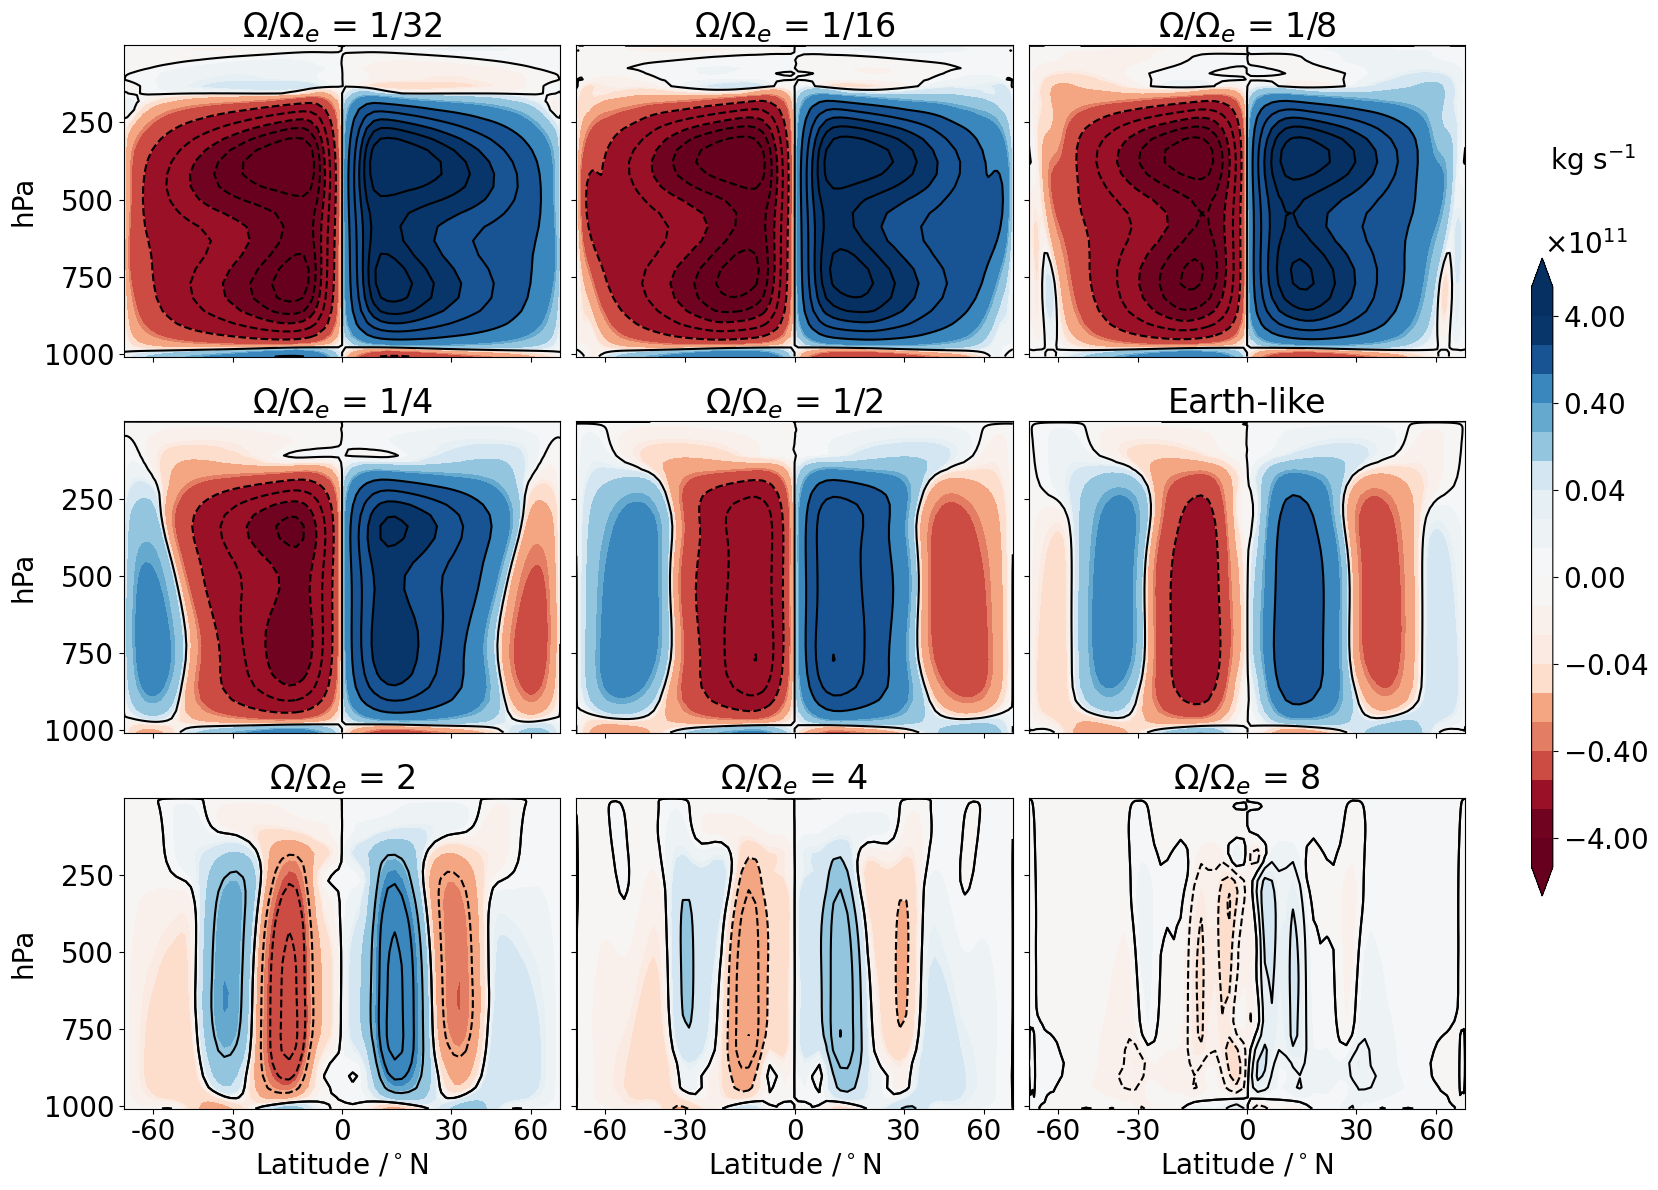

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import ScalarFormatter

# Constants
figsize = (18, 12)
ticks_deg = np.array([-60, -30, 0, 30, 60])
vmin, vmax = -5e11, 5.1e11
cmap = 'RdBu'
levels = np.array([-6e11, -4e11, -3e11, -1e11, -0.4e11, -0.3e11, -0.1e11,
                   -0.04e11, -0.03e11, -0.01e11, 0, 0.01e11, 0.03e11, 0.04e11, 0.1e11,
                   0.3e11, 0.4e11, 1e11, 3e11, 4e11, 6e11])
titles = [
    r'$\Omega/\Omega_e$ = 1/32', r'$\Omega/\Omega_e$ = 1/16', r'$\Omega/\Omega_e$ = 1/8',
    r'$\Omega/\Omega_e$ = 1/4', r'$\Omega/\Omega_e$ = 1/2', 'Earth-like',
    r'$\Omega/\Omega_e$ = 2', r'$\Omega/\Omega_e$ = 4', r'$\Omega/\Omega_e$ = 8'
]

# Create figure and axes
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=figsize, sharey='row', sharex='col')
ax = ax.ravel()

# Meshgrid for plotting
x, y = np.meshgrid(np.sin(np.deg2rad(z1.lat)), z1.plev / 100)

# Plotting
for i, axis in enumerate(ax):
    cont = axis.contourf(x, y, z1[i], cmap=cmap, levels=levels,
                         norm=SymLogNorm(linthresh=0.1e11, linscale=0.5, vmin=-4e11, vmax=4e11), extend='both')

    cont_interval = 1e11 if i < 4 else 1e11
    axis.contour(x, y, z1[i], colors='k', levels=np.arange(vmin, vmax, cont_interval))
    #axis.contour(x, y, z2[i], colors='lightgrey', levels=np.arange(vmin, vmax, cont_interval))

    axis.xaxis.set_ticks(np.sin(np.deg2rad(ticks_deg)))
    axis.set_xticklabels(ticks_deg)
    axis.set_title(titles[i], fontsize=24)
    #axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))

    if i % 3 == 0:
        axis.invert_yaxis()
        axis.set_ylabel('hPa', size=20)

    if i >= 6:
        axis.set_xlabel('Latitude /' r'$^\circ$N', size=20)
        specific_intervals = {
            6: np.arange(-2e11, 2e11, 0.25e11),
            7: np.arange(-1.5e11, 1.51e11, 0.1e11),
            8: np.arange(-1e11, 1.1e11, 0.02e11)
        }
        if i in specific_intervals:
            axis.contour(x, y, z1[i], colors='k', levels=specific_intervals[i], vmin=vmin, vmax=vmax)
            #axis.contour(x, y, z2[i], colors='grey', levels=specific_intervals[i], vmin=vmin, vmax=vmax)

    #axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))
    axis.xaxis.set_tick_params(labelsize=20)
    axis.yaxis.set_tick_params(labelsize=20)

plt.tight_layout()
cbar = fig.colorbar(cont, ax=ax, shrink=0.6, location='right', pad=0.04, aspect=30)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('kg s$^{-1}$', rotation=0, fontsize=20, labelpad=-40, y=1.25)
# Set colorbar to scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
offset_text = cbar.ax.yaxis.offsetText
offset_text.set_fontsize(20)
offset_text.set_x(4.5)

plt.savefig('Figures/mastrfu.pdf')

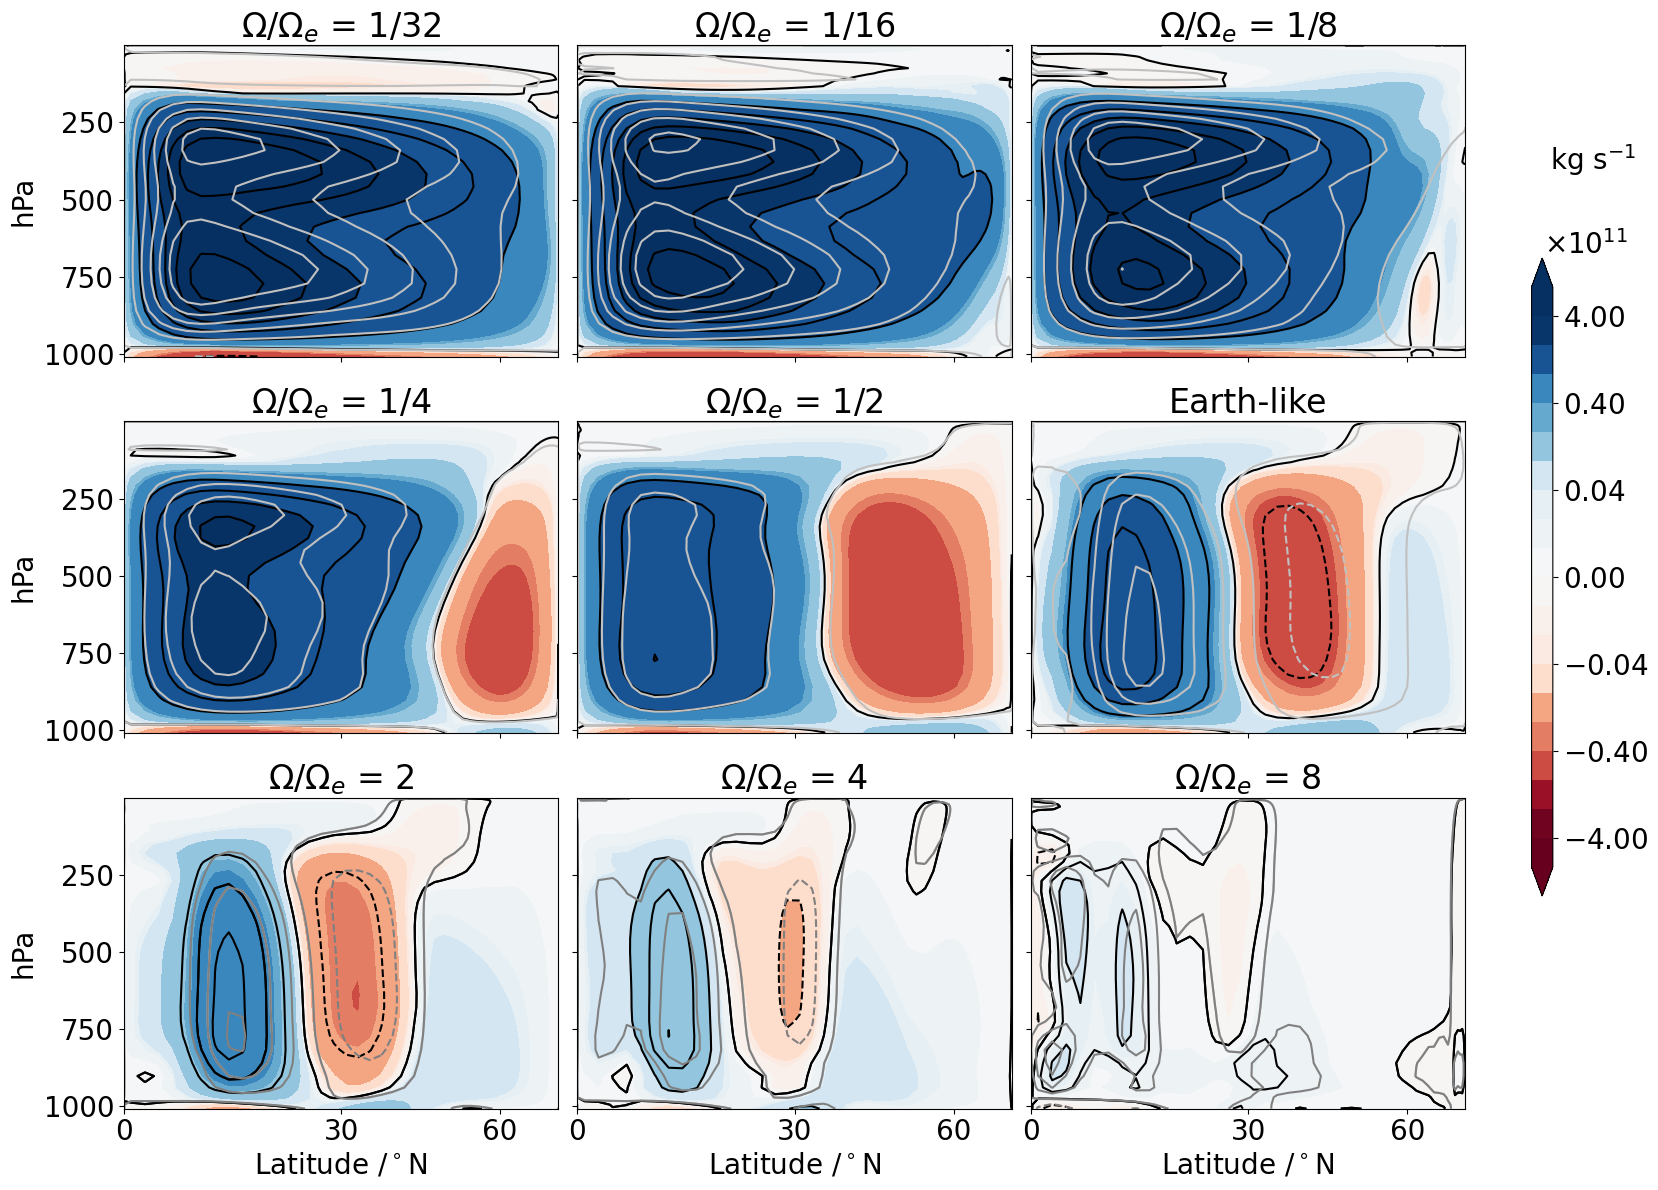

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import ScalarFormatter

# Constants
figsize = (18, 12)
ticks_deg = np.array([-60, -30, 0, 30, 60])
vmin, vmax = -5e11, 5.1e11
cmap = 'RdBu'
levels = np.array([-6e11, -4e11, -3e11, -1e11, -0.4e11, -0.3e11, -0.1e11,
                   -0.04e11, -0.03e11, -0.01e11, 0, 0.01e11, 0.03e11, 0.04e11, 0.1e11,
                   0.3e11, 0.4e11, 1e11, 3e11, 4e11, 6e11])
titles = [
    r'$\Omega/\Omega_e$ = 1/32', r'$\Omega/\Omega_e$ = 1/16', r'$\Omega/\Omega_e$ = 1/8',
    r'$\Omega/\Omega_e$ = 1/4', r'$\Omega/\Omega_e$ = 1/2', 'Earth-like',
    r'$\Omega/\Omega_e$ = 2', r'$\Omega/\Omega_e$ = 4', r'$\Omega/\Omega_e$ = 8'
]

# Create figure and axes
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=figsize, sharey='row', sharex='col')
ax = ax.ravel()

# Meshgrid for plotting
x, y = np.meshgrid(np.sin(np.deg2rad(z1.lat)), z1.plev / 100)

# Plotting
for i, axis in enumerate(ax):
    cont = axis.contourf(x, y, z1[i], cmap=cmap, levels=levels,
                         norm=SymLogNorm(linthresh=0.1e11, linscale=0.5, vmin=-4e11, vmax=4e11), extend='both')

    cont_interval = 1e11 if i < 5 else 0.5e11
    axis.contour(x, y, z1[i], colors='k', levels=np.arange(vmin, vmax, cont_interval))
    axis.contour(x, y, z2[i], colors='silver', levels=np.arange(vmin, vmax, cont_interval))

    axis.xaxis.set_ticks(np.sin(np.deg2rad(ticks_deg)))
    axis.set_xticklabels(ticks_deg)
    axis.set_title(titles[i], fontsize=24)
    axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))

    if i % 3 == 0:
        axis.invert_yaxis()
        axis.set_ylabel('hPa', size=20)

    if i >= 6:
        axis.set_xlabel('Latitude /' r'$^\circ$N', size=20)
        specific_intervals = {
            6: np.arange(-2e11, 2e11, 0.25e11),
            7: np.arange(-1.5e11, 1.51e11, 0.1e11),
            8: np.arange(-1e11, 1.1e11, 0.02e11)
        }
        if i in specific_intervals:
            axis.contour(x, y, z1[i], colors='k', levels=specific_intervals[i], vmin=vmin, vmax=vmax)
            axis.contour(x, y, z2[i], colors='grey', levels=specific_intervals[i], vmin=vmin, vmax=vmax)

    #axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))
    axis.xaxis.set_tick_params(labelsize=20)
    axis.yaxis.set_tick_params(labelsize=20)

plt.tight_layout()
cbar = fig.colorbar(cont, ax=ax, shrink=0.6, location='right', pad=0.04, aspect=30)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('kg s$^{-1}$', rotation=0, fontsize=20, labelpad=-40, y=1.25)
# Set colorbar to scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
offset_text = cbar.ax.yaxis.offsetText
offset_text.set_fontsize(20)
offset_text.set_x(4.5)

plt.savefig('Figures/mastrfu.pdf')

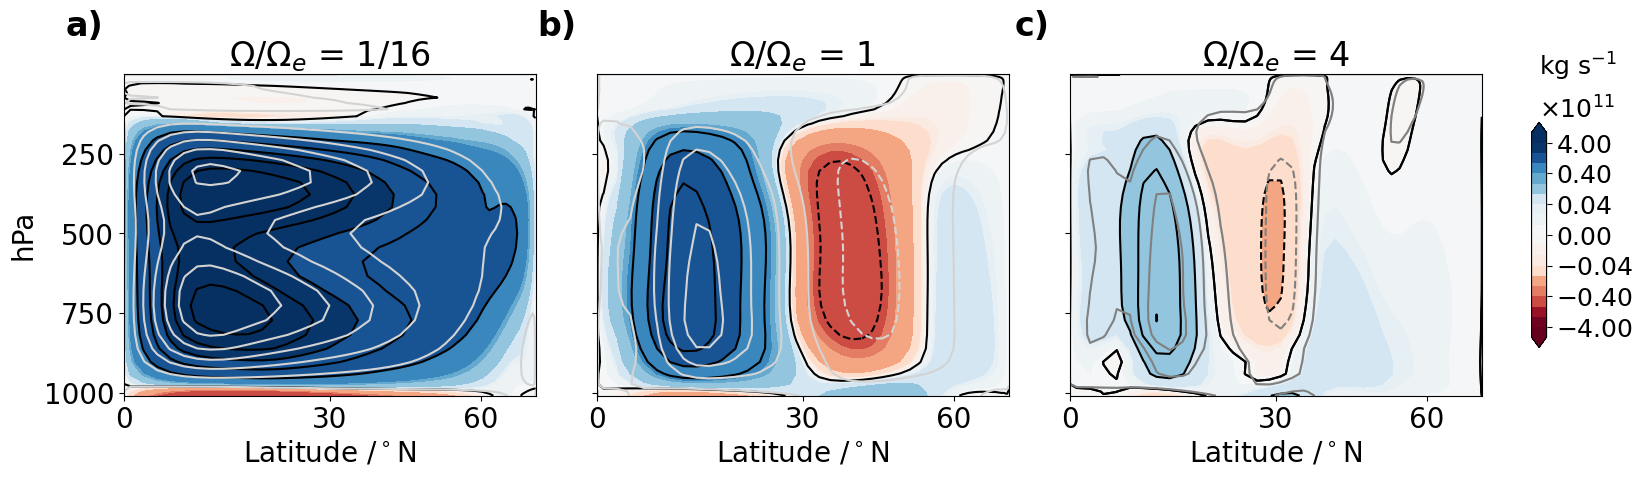

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import ScalarFormatter

z1 = z1.sel(rotation=['1/16','Earth-like', '4'])
z2 = z2.sel(rotation=['1/16','Earth-like', '4'])

# Constants
figsize = (18, 5)
ticks_deg = np.array([-60, -30, 0, 30, 60])
vmin, vmax = -5e11, 5.1e11
cmap = 'RdBu'
levels = np.array([-6e11, -4e11, -3e11, -1e11, -0.4e11, -0.3e11, -0.1e11,
                   -0.04e11, -0.03e11, -0.01e11, 0, 0.01e11, 0.03e11, 0.04e11, 0.1e11,
                   0.3e11, 0.4e11, 1e11, 3e11, 4e11, 6e11])
titles = [ r'$\Omega/\Omega_e$ = 1/16', r'$\Omega/\Omega_e$ = 1', 
          r'$\Omega/\Omega_e$ = 4'
]


# Create figure and axes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize, sharey='row', sharex='col')
ax = ax.ravel()

# Meshgrid for plotting
x, y = np.meshgrid(np.sin(np.deg2rad(z1.lat)), z1.plev / 100)

subplot_labels = ['a)', 'b)', 'c)']

# Plotting
for i, axis in enumerate(ax):

    axis.text(-0.05, 1.2, subplot_labels[i], transform=axis.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
    
    cont = axis.contourf(x, y, z1[i], cmap=cmap, levels=levels,
                         norm=SymLogNorm(linthresh=0.1e11, linscale=0.5, vmin=-4e11, vmax=4e11), extend='both')

    cont_interval = 1e11 if i < 1 else 0.5e11
    axis.contour(x, y, z1[i], colors='k', levels=np.arange(vmin, vmax, cont_interval))
    axis.contour(x, y, z2[i], colors='lightgrey', levels=np.arange(vmin, vmax, cont_interval))

    axis.xaxis.set_ticks(np.sin(np.deg2rad(ticks_deg)))
    axis.set_xticklabels(ticks_deg)
    axis.set_title(titles[i], fontsize=24)
    axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))

    if i == 0:
        axis.invert_yaxis()
        axis.set_ylabel('hPa', size=20)

    if i >= 2:
        specific_intervals = {
            1: np.arange(-2e11, 2e11, 0.25e11),
            2: np.arange(-1.5e11, 1.51e11, 0.1e11)
        }
        if i in specific_intervals:
            axis.contour(x, y, z1[i], colors='k', levels=specific_intervals[i], vmin=vmin, vmax=vmax)
            axis.contour(x, y, z2[i], colors='grey', levels=specific_intervals[i], vmin=vmin, vmax=vmax)

    #axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))
    axis.xaxis.set_tick_params(labelsize=20)
    axis.yaxis.set_tick_params(labelsize=20)
    axis.set_xlabel('Latitude /' r'$^\circ$N', size=20)

plt.tight_layout()
cbar = fig.colorbar(cont, ax=ax, shrink=0.7, location='right', pad=0.03, aspect=15)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('kg s$^{-1}$', rotation=0, fontsize=18, labelpad=-40, y=1.4)
# Set colorbar to scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
offset_text = cbar.ax.yaxis.offsetText
offset_text.set_fontsize(18)
offset_text.set_x(5.5)

plt.savefig('Figures/mastrfu.pdf')

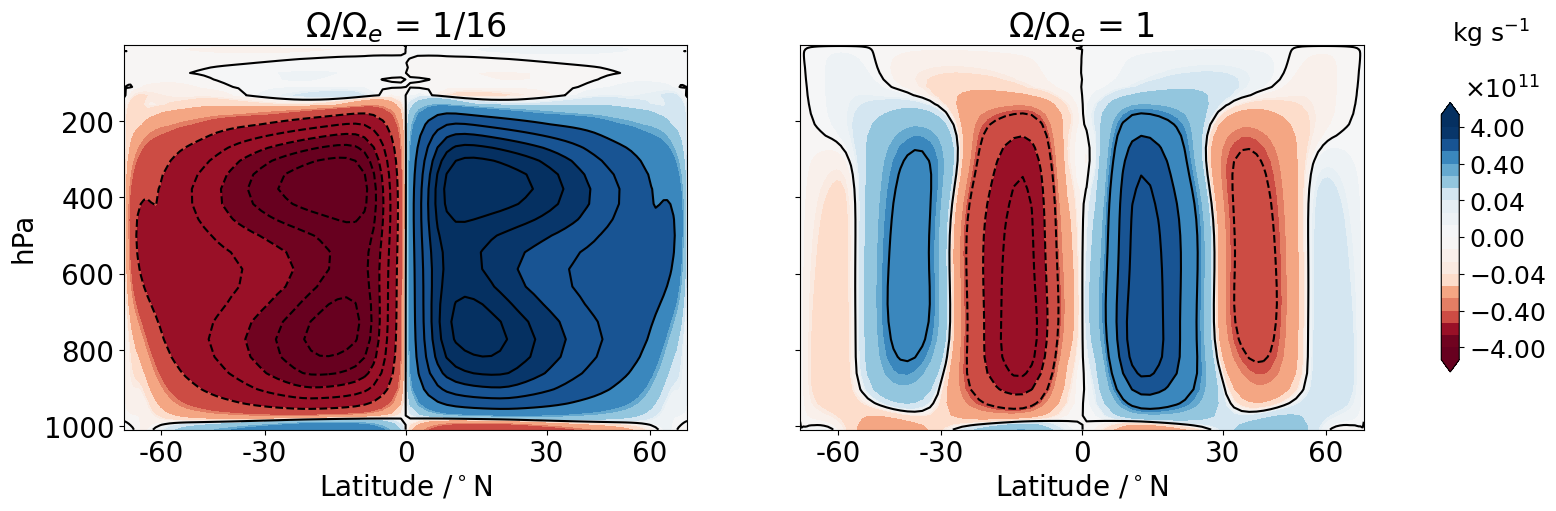

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import ScalarFormatter

z1 = z1.sel(rotation=['1/16','Earth-like'])#, '4'])
z2 = z2.sel(rotation=['1/16','Earth-like'])#, '4'])

# Constants
figsize = (20, 5)  
#figsize = (9, 9)
ticks_deg = np.array([-60, -30, 0, 30, 60])
yticks = np.array([1000, 500, 100])
vmin, vmax = -5e11, 5.1e11
cmap = 'RdBu'
levels = np.array([-6e11, -4e11, -3e11, -1e11, -0.4e11, -0.3e11, -0.1e11,
                   -0.04e11, -0.03e11, -0.01e11, 0, 0.01e11, 0.03e11, 0.04e11, 0.1e11,
                   0.3e11, 0.4e11, 1e11, 3e11, 4e11, 6e11])
titles = [ r'$\Omega/\Omega_e$ = 1/16', r'$\Omega/\Omega_e$ = 1']#, 
#          r'$\Omega/\Omega_e$ = 4'
#]

# Create figure and axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey='row', sharex='col')
ax = ax.ravel()

# Meshgrid for plotting
x, y = np.meshgrid(np.sin(np.deg2rad(z1.lat)), z1.plev / 100)

# Plotting
for i, axis in enumerate(ax):
    cont = axis.contourf(x, y, z1[i], cmap=cmap, levels=levels,
                         norm=SymLogNorm(linthresh=0.1e11, linscale=0.5, vmin=-4e11, vmax=4e11), extend='both')

    cont_interval = 1e11 if i < 1 else 0.5e11
    axis.contour(x, y, z1[i], colors='k', levels=np.arange(vmin, vmax, cont_interval))

    axis.xaxis.set_ticks(np.sin(np.deg2rad(ticks_deg)))
    axis.set_xticklabels(ticks_deg)
    axis.set_title(titles[i], fontsize=24)
    #axis.set_xlim(0, np.sin(np.deg2rad(z1.lat[0])))

    if i == 0:
        axis.invert_yaxis()
        axis.set_ylabel('hPa', size=20)

    if i >= 2:
        specific_intervals = {
            1: np.arange(-2e11, 2e11, 0.25e11),
            2: np.arange(-1.5e11, 1.51e11, 0.1e11)
        }
        if i in specific_intervals:
            axis.contour(x, y, z1[i], colors='k', levels=specific_intervals[i], vmin=vmin, vmax=vmax)

     
    axis.xaxis.set_tick_params(labelsize=20)
    axis.yaxis.set_tick_params(labelsize=20)
    axis.set_xlabel('Latitude /' r'$^\circ$N', size=20)
        
    

#plt.tight_layout()
cbar = fig.colorbar(cont, ax=ax, shrink=0.7, location='right', pad=0.05, aspect=15)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('kg s$^{-1}$', rotation=0, fontsize=18, labelpad=-40, y=1.4)
# Set colorbar to scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
offset_text = cbar.ax.yaxis.offsetText
offset_text.set_fontsize(18)
offset_text.set_x(5.5)

plt.savefig('Figures/mastrfu.pdf')

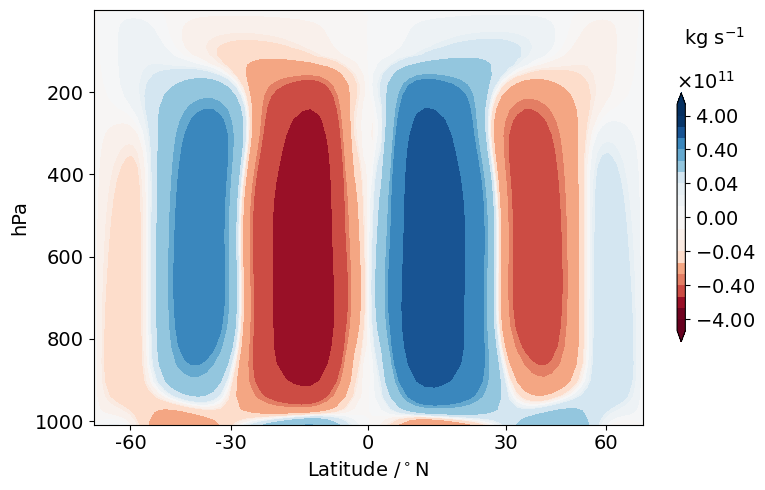

In [17]:


data = z1.sel(rotation='Earth-like')
x, y = np.meshgrid(np.sin(np.deg2rad(z1.lat)),data.plev/100)
    
fig,ax = plt.subplots(figsize=(8,5))
ticks_deg = np.array([ -60, -30, 0, 30, 60])
title = ''

ticks_deg = np.array([-60, -30, 0, 30, 60])
vmin, vmax = -5e11, 5.1e11
cmap = 'RdBu'
levels = np.array([-6e11, -4e11, -3e11, -1e11, -0.4e11, -0.3e11, -0.1e11,
                   -0.04e11, -0.03e11, -0.01e11, 0, 0.01e11, 0.03e11, 0.04e11, 0.1e11,
                   0.3e11, 0.4e11, 1e11, 3e11, 4e11, 6e11])
    
cont = ax.contourf(x, y, data, cmap=cmap, levels=levels,
                         norm=SymLogNorm(linthresh=0.1e11, linscale=0.5, vmin=-4e11, vmax=4e11), extend='both')

#ax.contour(x, y, data, colors='k', levels=np.arange(vmin, vmax, 1e11))
ax.xaxis.set_ticks(list(np.sin(np.deg2rad(ticks_deg))))
ax.set_xticklabels(ticks_deg)
ax.set_title(title,fontsize=18)
ax.invert_yaxis()
ax.set_ylabel('hPa', size=14)
    #ax.set_xlim(0,np.sin(np.deg2rad(data.lat[0])))
ax.set_xlabel('Latitude /'r'$^\circ$N', size=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
    
plt.tight_layout()
cbar=fig.colorbar(cont, ax=ax, shrink=0.6, location='right',pad=0.05,aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('kg s$^{-1}$', rotation=0, fontsize=14, labelpad=-30, y=1.35)
# Set colorbar to scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
offset_text = cbar.ax.yaxis.offsetText
offset_text.set_fontsize(14)
offset_text.set_x(7)
plt.savefig('Figures/mastrfu_earth.pdf')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import ScalarFormatter
from matplotlib.animation import FuncAnimation
from PIL import Image

# Assuming z1 and temperature_data are already defined
data = z1.sel(rotation='Earth-like')
x, y = np.meshgrid(np.sin(np.deg2rad(z1.lat)), data.plev / 100)

fig, ax = plt.subplots(figsize=(8, 5))
ticks_deg = np.array([-60, -30, 0, 30, 60])
title = ''

vmin, vmax = -5e11, 5.1e11
cmap_stream = 'RdBu'
levels_stream = np.array([-6e11, -4e11, -3e11, -1e11, -0.4e11, -0.3e11, -0.1e11,
                          -0.04e11, -0.03e11, -0.01e11, 0, 0.01e11, 0.03e11, 0.04e11, 0.1e11,
                          0.3e11, 0.4e11, 1e11, 3e11, 4e11, 6e11])

# Plot mass stream function
cont_stream = ax.contourf(x, y, data, cmap=cmap_stream, levels=levels_stream,
                          norm=SymLogNorm(linthresh=0.1e11, linscale=0.5, vmin=-4e11, vmax=4e11), extend='both')

ax.contour(x, y, data, colors='k', levels=np.arange(vmin, vmax, 1e11))
ax.xaxis.set_ticks(list(np.sin(np.deg2rad(ticks_deg))))
ax.set_xticklabels(ticks_deg)
ax.set_title(title, fontsize=18)
ax.invert_yaxis()
ax.set_ylabel('hPa', size=14)
ax.set_xlabel('Latitude /'r'$^\circ$N', size=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()
cbar = fig.colorbar(cont_stream, ax=ax, shrink=0.6, location='right', pad=0.05, aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('kg s$^{-1}$', rotation=0, fontsize=14, labelpad=-30, y=1.35)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
offset_text = cbar.ax.yaxis.offsetText
offset_text.set_fontsize(14)
offset_text.set_x(7)

# Plot temperature contours but initially set them to invisible
cmap_temp = 'Greys'
levels_temp = np.arange(240, 270, 5)
cont_temp = ax.contour(x, y, temperature_data, cmap=cmap_temp, levels=levels_temp, extend='both')
for collection in cont_temp.collections:
    collection.set_visible(False)

# Animation function to toggle visibility
def animate(frame):
    visible = frame % 2 == 1
    for collection in cont_temp.collections:
        collection.set_visible(visible)
    return cont_temp.collections

# Create animation
anim = FuncAnimation(fig, animate, frames=2, interval=1000, blit=True)

# Save animation
anim.save('toggle_temperature.gif', writer='imagemagick', fps=1)

# Modify GIF to loop only once
with Image.open('toggle_temperature.gif') as img:
    img.save('toggle_temperature_once.gif', loop=0)

plt.show()